In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 12 20:56:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install scikit-optimize
#hyper-parameters tuning
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import load
from skopt.plots import plot_objective, plot_histogram, plot_convergence

In [ ]:
!pip install yfinance
# finance dataset
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
######### Import Libraries ###########
# basics
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import enum
from tqdm import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import autograd

#statistics
import scipy.integrate as integrate 
from scipy.stats import norm
import statsmodels.distributions as smd
from scipy.special import rel_entr
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from sklearn.metrics import confusion_matrix
import scipy.stats as sts
# not used
# import matplotlib.animation as anim
# from IPython.display import HTML

device = torch.device('cuda:0' if (torch.cuda.is_available() ) else 'cpu')
print(device)

cuda:0


 **WGAN's Architecture**

In [ ]:
#-- Discriminator/Critic

class Critic(nn.Module):
    " A dense net"
    def __init__(self, 
                 c_dim = 2, # conditional dimension
                 input_dim = 1,
                 output_dim = 1,
                 hidden_neurons = [200,200,200,200], 
                 activation = nn.LeakyReLU(0.1)
                 ):
        super(Critic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + c_dim ,hidden_neurons[0],bias = False),
            activation,
            nn.Linear(hidden_neurons[0],hidden_neurons[1],bias = False),
            activation,
            nn.Linear(hidden_neurons[1],hidden_neurons[2],bias = False),
            activation,
            nn.Linear(hidden_neurons[2],hidden_neurons[3],bias = False),
            activation,
            nn.Linear(hidden_neurons[3],output_dim)
        )
    def forward(self,x):
        output = self.model(x)
        return output

#-- Generator

class Generator(nn.Module):
    def __init__(self,
                 c_dim = 2, # conditional dimension
                 input_dim = 1,
                 output_dim = 1,
                 hidden_neurons = [200,200,200,200], 
                 activation = nn.LeakyReLU(0.1)
                 ):
        super(Generator, self).__init__()
   
        self.model = nn.Sequential(
            nn.Linear(input_dim + c_dim, hidden_neurons[0],bias = False),
            activation,
            nn.Linear(hidden_neurons[0],hidden_neurons[1],bias = False),
            activation,
            nn.Linear(hidden_neurons[1],hidden_neurons[2],bias = False),
            activation,
            nn.Linear(hidden_neurons[2],hidden_neurons[3],bias = False),
            activation,
            nn.Linear(hidden_neurons[3],output_dim)
        )
    def forward(self,x):
        output = self.model(x)
        return output

In [ ]:
class jumpType(enum.Enum):
    fixJ = 1.0
    mertonJ = -1.0

class RealData():
    """
    The dataset: log-price
    """
    def __init__(self, 
                 modelpara,
                 jumptype,
                 jumppara):
        
        self.nsteps = modelpara['nsteps']
        self.ndepths = modelpara['ndepths']
        self.T = modelpara['T']
        self.mu = modelpara['mu']
        self.sigma = modelpara['sigma']
        self.dt = modelpara['T'] /float(modelpara['nsteps'])
        self.xiP = jumppara['xiP']
        print("Jump intensity: ", self.dt * self.xiP )
        if self.dt * self.xiP > 1:
            raise TypeError("Wrong jump setting parameters: jump intensity should not be larger than 1!")
        self.jumptype = jumptype
        self.jumppara = jumppara

        
    def generate_GBM(self, S0=100, npaths = 1000):
        """
        Generate the main GBM path
        """
        X0 = np.log(S0)
        GBM_X = np.zeros([npaths,self.nsteps+1])
        Z = np.random.normal(0.0, 1.0, [npaths,self.nsteps])
        GBM_X[:,0] = X0
        for i in range(self.nsteps):
            #Make sure that samples from a normal have mean 0 and variance 1
            if npaths > 1:
                    Z[:,i] = (Z[:,i]-np.mean(Z[:,i]))/np.std(Z[:,i])  
            GBM_X[:,i+1] = GBM_X[:,i] + self.mu* self.dt\
                             + self.sigma * np.sqrt(self.dt) * Z[:,i]
        return GBM_X
    def generate_Monte_GBM(self, GBM_X):
        """
        Generate the 3D dataset
        """
        X0 = GBM_X[0,0]
        npaths= GBM_X.shape[0]
        Monte_GBM_X = np.zeros([npaths,self.nsteps+1,self.ndepths])
        Monte_Z = np.random.normal(loc=0.0, scale=1.0, 
                                   size=[npaths,self.nsteps,self.ndepths-1])
        Monte_GBM_X[:,0,:] = X0
        Monte_GBM_X[:,:,0] = GBM_X
        for i in range(self.nsteps):
            for j in range(npaths):
                # if self.ndepths > 1:
                #     Monte_Z[j,i,:] = (Monte_Z[j,i,:] - np.mean(Monte_Z[j,i,:]))\
                #                     / np.std(Monte_Z[j,i,:])
                Monte_GBM_X[j,i+1,1:] = GBM_X[j,i] + self.mu * self.dt \
                                    + self.sigma * np.sqrt(self.dt) * Monte_Z[j,i,:]
        return Monte_GBM_X
    
    def generate_fixJ_path(self, GBM_X):
        if self.jumptype.value == -1.0: # The parameters are follow Merton's jump
            raise TypeError("Wrong jump type!")
        else:
            print('Jump type:', self.jumptype)
            X0 = GBM_X[0,0]
            npaths= GBM_X.shape[0]
            p = self.jumppara['p']
            Jsize = self.jumppara['J']
            jump_X = np.zeros([npaths,self.nsteps+1])
            Bernoulli = np.random.binomial(n=1, p=self.xiP * self.dt, 
                                           size=[npaths,self.nsteps])  
            jump_X[:,0] = X0 
            U = np.random.uniform(low=0,high=1,
                                  size=[npaths,self.nsteps])
            J = np.zeros([npaths,self.nsteps])
            for i in range(npaths):
                for j in range(self.nsteps):
                    if U[i,j] <= p:
                        J[i,j] = Jsize
                    else:
                        J[i,j] = -Jsize
            jumpPart = J * Bernoulli
            cum_jump = np.cumsum(jumpPart, axis = 1)
            for i in range(self.nsteps): 
                jump_X[:,i+1] =  GBM_X[:,i+1] + cum_jump[:,i]
        
        return jump_X, Bernoulli, J

    def generate_mertonJ_path(self, GBM_X):
        if self.jumptype.value == 1.0:
            
            raise TypeError("Wrong jump type!")
        else:
            print('Jump type:', self.jumptype)
            X0 = GBM_X[0,0]
            npaths= GBM_X.shape[0]
            muJ = self.jumppara['muJ']
            sigmaJ = self.jumppara['sigmaJ']
            jump_X = np.zeros([npaths,self.nsteps+1])
            Bernoulli = np.random.binomial(n=1, p=self.xiP * self.dt, 
                                           size=[npaths,self.nsteps])  
            jump_X[:,0] = X0 
            J = np.random.normal(loc = muJ, scale = sigmaJ, 
                                 size = [npaths,self.nsteps])
            jumpPart = J * Bernoulli
            cum_jump = np.cumsum(jumpPart, axis = 1)
            for i in range(self.nsteps): 
                jump_X[:,i+1] = GBM_X[:,i+1] +  cum_jump[:,i]
        
        return jump_X, Bernoulli, J
    def generate_MontemertonJ(self, Monte_GBM_X,Bernoulli, J):
        if self.jumptype.value == 1.0:
            
            raise TypeError("Wrong jump type!")
        else:
            print('Jump type:', self.jumptype)
            X0 = Monte_GBM_X[0,0,0]
            npaths= Monte_GBM_X.shape[0]
            muJ = self.jumppara['muJ']
            sigmaJ = self.jumppara['sigmaJ']
            jump_X = np.zeros([npaths,self.nsteps+1,self.ndepths])
            # Bernoulli = np.random.binomial(n=1, p=self.xiP * self.dt, 
            #                                size=[npaths,self.nsteps])  
            jump_X[:,0] = X0 
            # J = np.random.normal(loc = muJ, scale = sigmaJ, 
            #                      size = [npaths,self.nsteps])
            jumpPart = J * Bernoulli
            cum_jump = np.cumsum(jumpPart, axis = 1)
            for i in range(self.nsteps): 
                for k in range(self.ndepths):
                    jump_X[:,i+1,k] = Monte_GBM_X[:,i+1,k] +  cum_jump[:,i]
        
        return jump_X

    def build_trainloader(self, batch_size = 100, S0 = 100, npaths = 2000):
        initialS0 = [int(S0/100),
                     int(S0/10),
                     S0,
                     int(S0*10),
                     int(S0*100)]
        nparts = len(initialS0)
        Monte_GBMXs = np.zeros([int(npaths*nparts), 
                                self.nsteps+1, 
                                self.ndepths])
        for l in range(nparts):
            GBM_X = self.generate_GBM(initialS0[l],npaths)
            Monte_GBM_X = self.generate_Monte_GBM(GBM_X)
           
            Monte_GBMXs[npaths*l: npaths*(l+1),:] = Monte_GBM_X
        Monte_GBMXs = torch.tensor(Monte_GBMXs,
                                   dtype=torch.float32) 
        train_loader = DataLoader(Monte_GBMXs,
                                  batch_size=batch_size,
                                  shuffle=True)
        return train_loader



In [ ]:
class TrainDistribution():
    def __init__(
        self,
        generator,
        critic, 
        generator_optimizer,
        critic_optimizer,
        trainloader,
        lr_step,
        lr_gamma,
        min_lr,
        critic_iter,
        gp_lambda,
        latent_dim,
        model_para,
        device
        ):
        
        self.generator = generator
        self.critic = critic
        self.generator_optimizer = generator_optimizer
        self.critic_optimizer = critic_optimizer

        self.device = device

        self.trainloader = trainloader
        self.latent_dim = latent_dim
        self.model_para = model_para
        self.critic_iter = critic_iter
        self.gp_lambda = gp_lambda
        self.min_lr = min_lr

        self.critic_scheduler = torch.optim.lr_scheduler.StepLR(
            self.critic_optimizer, 
            step_size = lr_step, 
            gamma = lr_gamma
            )
        self.generator_scheduler = torch.optim.lr_scheduler.StepLR(
            self.generator_optimizer, 
            step_size = lr_step, 
            gamma = lr_gamma
            )
  
    def prepare_data(self, MonteXt): 
        """
        Input: 
            MonteXt: [npaths,nsteps,ndepth], the log-GBM training dataset using nested Monte Carlo
        Output:
            dt: [npaths,ndepth], the condition regarding the timestep 
            Monte_X0: [npaths, ndepth], the condition regarding the current state
            real_Monte_Xt: [npaths,ndepth], the real future state
        """
        MonteXt = MonteXt.to(self.device)
        indices = np.random.randint(self.model_para['nsteps'])
        delta_t = self.model_para['T']/float(self.model_para['nsteps'])
        dt = torch.tensor(
            np.ones([MonteXt.size(0),MonteXt.size(2)])*delta_t, 
            dtype=torch.float32,
            device=self.device
            )
        Monte_X0 = MonteXt[:,indices,:].to(self.device)
        real_Monte_Xt = MonteXt[:,indices+1,:].to(self.device)

        return dt, Monte_X0, real_Monte_Xt
    
    def calculate_gradient_penalty(self, real_samples, fake_samples):

        length = real_samples.size(0)
        depth = real_samples.size(1)

        eta = torch.FloatTensor(length,1).uniform_(0,1)
        eta = eta.expand(length, depth)
        eta = eta.to(self.device)

        interpolated = (eta * real_samples \
                        + ((1 - eta) * fake_samples)).to(self.device)

        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.critic(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs = prob_interpolated, 
                                inputs = interpolated,
                                grad_outputs = torch.ones(
                                    prob_interpolated.size()).to(self.device),
                                create_graph = True, 
                                retain_graph = True)[0]

        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() \
                        * self.gp_lambda

        return grad_penalty
  
    def train_critic_step(self, dt, Monte_X0, real_Monte_Xt):

        length = real_Monte_Xt.size(0)
        depth = self.latent_dim

        # initialize latent variable
        z = np.random.normal(0.0, 1.0,[length,depth])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(self.device) 
        
        # Conditioned real samples
     
        conditional_real_samples = torch.cat(                                   
                                        (real_Monte_Xt, dt, Monte_X0), 
                                        dim = -1
                                        )
        
        # The conditioned input of the generator
        conditional_fake_latent_samples = torch.cat(                            
                                        (z, dt, Monte_X0),
                                        dim = -1
                                        )
        # The output of the generator
        G_z = self.generator(conditional_fake_latent_samples)                   
        # Conditioned generated samples
        conditional_fake_samples = torch.cat(                                   
                                        (G_z,dt,Monte_X0),
                                        dim = -1)
        
        self.critic.zero_grad() 

        # Add gradient penalty
        gradient_penalty = self.calculate_gradient_penalty(
                                    conditional_real_samples,
                                    conditional_fake_samples,
                                    )
        gradient_penalty.backward(retain_graph=True)

        # Calculate the critic loss
        loss_D = \
        self.critic(conditional_fake_samples).mean() \
        - self.critic(conditional_real_samples).mean() \
        + gradient_penalty

        loss_D.backward(retain_graph=True)

        self.critic_optimizer.step()

        return loss_D.item()
  
    def train_generator_step(self, dt, Monte_X0, real_Monte_Xt):

        length = real_Monte_Xt.size(0)
        depth = self.latent_dim

        # Initial latent variable
        z = np.random.normal(0.0, 1.0,[length,depth])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(self.device)

        # The conditioned input of the generator
        conditional_fake_latent_samples = torch.cat(
                                                (z, dt, Monte_X0),
                                                dim = -1) 
        # The output of the generator
        for p in self.critic.parameters():
            p.requires_grad = False

        self.generator.zero_grad()

        G_z = self.generator(conditional_fake_latent_samples)

        # save the output of the generator: G(z,dt,Xt)
        generated_pattern = G_z.cpu().detach().numpy()
    
        # The conditioned generated samples
        conditional_fake_samples = torch.cat(
                                        (G_z, dt, Monte_X0),
                                        dim = -1)
        
        # Calculate the generator loss
        loss_G = - self.critic(conditional_fake_samples).mean()
        loss_G.backward()

        self.generator_optimizer.step()

        return generated_pattern, loss_G.item() 

    def trainingloop(self, nepochs):
        D_losses = []
        G_losses = []
        Generated_results = []
        

        for epoch in range(nepochs):
            D_loss_acc = 0
            G_loss_acc = 0

            self.critic.train()
            self.generator.train()

            progress_bar = tqdm(self.trainloader, unit="batch")
            for i, MonteXt in enumerate(progress_bar):

                dt, Monte_X0, real_Monte_Xt = self.prepare_data(MonteXt)
      
                for p in critic.parameters():
                    p.requires_grad = True

                # Training the critic
                for iter in range(self.critic_iter): 
                    critic_loss = self.train_critic_step(dt, 
                                                         Monte_X0, 
                                                         real_Monte_Xt)
                    D_loss_acc += critic_loss

                # Training the generator
                generated_pattern, \
                generator_loss = self.train_generator_step(dt, 
                                                           Monte_X0, 
                                                           real_Monte_Xt)
                G_loss_acc += generator_loss
                
                progress_bar.set_description(f"Epoch {epoch+1}")
                progress_bar.set_postfix(avg_D_loss=D_loss_acc / 
                                         (i * self.critic_iter+1),                                              
                                         avg_G_loss=G_loss_acc / (i+1))

                D_losses.append(critic_loss)
                G_losses.append(generator_loss) 
                Generated_results.append(generated_pattern)
                

            if self.generator_scheduler.get_last_lr()[0] > self.min_lr:
                self.generator_scheduler.step()

            if self.critic_scheduler.get_last_lr()[0] > self.min_lr:
                self.critic_scheduler.step()

        return D_losses, G_losses, Generated_results
    def trainingloop_withKS(self, nepochs):
        D_losses = []
        G_losses = []
        Generated_results = []
        KS_value = []
        W1 = []
        

        for epoch in range(nepochs):
            D_loss_acc = 0
            G_loss_acc = 0

            self.critic.train()
            self.generator.train()

            progress_bar = tqdm(self.trainloader, unit="batch")
            for i, MonteXt in enumerate(progress_bar):

                dt, Monte_X0, real_Monte_Xt = self.prepare_data(MonteXt)
      
                for p in critic.parameters():
                    p.requires_grad = True

                # Training the critic
                for iter in range(self.critic_iter): 
                    critic_loss = self.train_critic_step(dt, 
                                                         Monte_X0, 
                                                         real_Monte_Xt)
                    D_loss_acc += critic_loss

                # Training the generator
                generated_pattern, \
                generator_loss = self.train_generator_step(dt, 
                                                           Monte_X0, 
                                                           real_Monte_Xt)
                G_loss_acc += generator_loss
                
                progress_bar.set_description(f"Epoch {epoch+1}")
                progress_bar.set_postfix(avg_D_loss=D_loss_acc / 
                                         (i * self.critic_iter+1),                                              
                                         avg_G_loss=G_loss_acc / (i+1))

                D_losses.append(critic_loss)
                G_losses.append(generator_loss) 
                Generated_results.append(generated_pattern)
                ks = sts.ks_2samp(np.reshape(generated_pattern,-1),
                                  np.reshape(real_Monte_Xt.cpu().detach().numpy(),-1))
                w = wasserstein_distance(np.reshape(generated_pattern,-1),
                                  np.reshape(real_Monte_Xt.cpu().detach().numpy(),-1))
                KS_value.append(ks[0])
                W1.append(w)

                

            if self.generator_scheduler.get_last_lr()[0] > self.min_lr:
                self.generator_scheduler.step()

            if self.critic_scheduler.get_last_lr()[0] > self.min_lr:
                self.critic_scheduler.step()

        return D_losses, G_losses, Generated_results, KS_value, W1

In [ ]:
class FitDistribution():
    def __init__(
        self,
        generator,
        critic, 
        fitmodelpara,
        device
        ):
        self.generator = generator
        self.critic = critic
        self.npaths = fitmodelpara['npaths']
        self.nsteps = fitmodelpara['nsteps']
        self.ndepths = fitmodelpara['ndepths']
        self.T = fitmodelpara['T']
        self.S0 = fitmodelpara['S0']
        self.mu = fitmodelpara['mu']
        self.sigma = fitmodelpara['sigma']
        self.dt = fitmodelpara['T'] /float(fitmodelpara['nsteps'])
    
    def fit(self,test_Monte_GBM):
        length = self.npaths
        depth = self.ndepths
        width = self.nsteps

        generate_GAN_Monte = np.zeros([length,width+1,depth])
        generate_GAN_Monte[:,0,:] = np.log(self.S0)
        dt = torch.tensor(np.ones([length,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(device)

        for i in range(width):
            z = np.random.normal(0.0, 1.0,[length,depth])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            X0 = test_Monte_GBM[:,i,:]
            x0 = torch.tensor(X0,dtype=torch.float32)
            x0 = x0.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,x0),
                                                        dim = -1)
            G_z = generator(conditional_fake_latent_samples)
            generate_GAN_Monte[:,i+1,:] = G_z.cpu().detach().numpy()
        return generate_GAN_Monte

    def GBM_fit(self,test_GBM):
        length = self.npaths
        depth = self.ndepths
        width = self.nsteps

        generate_GAN_Monte = np.zeros([length,width+1,depth])
        generate_GAN_Monte[:,0,:] = np.log(self.S0)
        dt = torch.torch.tensor(np.ones([length,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(device)

        for i in range(width):
            z = np.random.normal(0.0, 1.0,[length,depth])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            X0 = np.resize(test_GBM[:,i] , [length,depth])
            x0 = torch.tensor(X0,dtype=torch.float32)
            x0 = x0.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,x0),
                                                        dim = -1)
            G_z = generator(conditional_fake_latent_samples)
            generate_GAN_Monte[:,i+1,:] = G_z.cpu().detach().numpy()
        return generate_GAN_Monte

    def fitNextStep(self,currentXt):
        length = self.npaths
        depth = self.ndepths
        width = self.nsteps

        generate_GAN_Monte = np.zeros([length,1,depth])
        dt = torch.tensor(np.ones([length,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(device)

        
        z = np.random.normal(0.0, 1.0,[length,depth])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(device)

        X0 = currentXt
        x0 = torch.tensor(X0,dtype=torch.float32)
        x0 = x0.to(device)

        conditional_fake_latent_samples = torch.cat((z,dt,x0),
                                                    dim = -1)
        G_z = generator(conditional_fake_latent_samples)
        generate_GAN_Monte = G_z.cpu().detach().numpy()
        return generate_GAN_Monte

In [ ]:
def set_jumppara(jumptype, xiP, J, p, muJ, sigmaJ):
    if jumptype == jumpType.fixJ:
        jumppara = dict(xiP=xiP, J=J, p=p)
        return jumppara
    if jumptype == jumpType.mertonJ:
        jumppara = dict(xiP=xiP, muJ=muJ, sigmaJ=sigmaJ)
        return jumppara

jump_elements = {
    'xiP': 1,
    'J': 1,
    'p': 0.5,
    'muJ': 0.15,
    'sigmaJ': 0.1
}

modelPara = {
    'npaths': 10000,
    'nsteps': 500,
    'ndepths': 10,
    'T': 500*0.1,
    'S0': 100,
    'mu': 0.05,
    'sigma': 1.0
}

dataset_parameters = {
    'modelpara': modelPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}

training_parameters = {
  'lr_step': 20,
  'lr_gamma': 0.3,
  'min_lr': 1e-08,
  'critic_iter': 9,
  'gp_lambda': 60,
  'latent_dim': modelPara['ndepths'],
  'model_para': modelPara,
  'device': device
}

generator_params = {
  "c_dim": 2 *modelPara['ndepths'],
  "input_dim": modelPara['ndepths'],
  "output_dim": modelPara['ndepths'], 
  "hidden_neurons": [100,100,100,100],
  "activation":nn.LeakyReLU(0.1)
}
critic_params = {
  "c_dim": 2 *modelPara['ndepths'], 
  "input_dim": modelPara['ndepths'],
  "output_dim": 1,
  "hidden_neurons":  [100,100,100,100],
  "activation":nn.LeakyReLU(0.1)
}

### **Trainloader test**

In [ ]:
realdata = RealData(**dataset_parameters)
trainloader = realdata.build_trainloader(batch_size=100,
                                    S0 = modelPara['S0'], 
                                    npaths=2000)

Jump intensity:  0.1


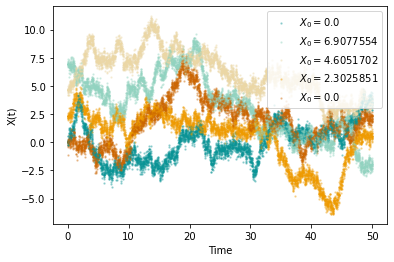

In [ ]:
# Test the trainloader
fig,ax = plt.subplots()
colors = [ '#099496','#91d3c0','#ebd7a5','#ee9b00','#cc6602']
x = np.linspace(0,modelPara['T'],modelPara['nsteps']+1)

for MonteX in trainloader:
  
    X0_list = [MonteX[10,0,0].numpy(),
               MonteX[30,0,0].numpy(),
               MonteX[50,0,0].numpy(),
               MonteX[70,0,0].numpy(),
               MonteX[90,0,0].numpy()] 
   
    for k in range(10):
        ax.scatter(x,MonteX[10,:,k],s=2,alpha = 0.3,color = colors[0], 
                   label = '$X_0=$'+str(X0_list[0]))
        ax.scatter(x,MonteX[30,:,k],s=2,alpha = 0.3,color = colors[1], 
                   label = '$X_0=$'+str(X0_list[1]))
        ax.scatter(x,MonteX[50,:,k],s=2,alpha = 0.3,color = colors[2], 
                   label = '$X_0=$'+str(X0_list[2]))
        ax.scatter(x,MonteX[70,:,k],s=2,alpha = 0.3,color = colors[3], 
                   label = '$X_0=$'+str(X0_list[3]))
        ax.scatter(x,MonteX[90,:,k],s=2,alpha = 0.3,color = colors[4], 
                   label = '$X_0=$'+str(X0_list[4]))
    break

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[1],handles[2],handles[3],handles[4]], 
          [labels[0],labels[1],labels[2],labels[3],labels[4]], loc='best')

plt.xlabel('Time')
plt.ylabel('X(t)')    
plt.show()

### **Training the SDE-WGAN**

In [ ]:
realdata = RealData(**dataset_parameters)
trainloader = realdata.build_trainloader(batch_size=100,
                                    S0 = modelPara['S0'], 
                                    npaths=2000)

Jump intensity:  0.1


In [ ]:


generator = Generator(**generator_params).to(device)
critic = Critic(**critic_params).to(device)

lr = 0.0003
generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)


trainer = TrainDistribution(
  generator=generator,
  critic=critic, 
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  trainloader = trainloader,
  **training_parameters
)

D_losses, G_losses, Generated_results, KS_value, W_1 = trainer.trainingloop_withKS(nepochs=100)

Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 16.28batch/s, avg_D_loss=-.318, avg_G_loss=-.234]


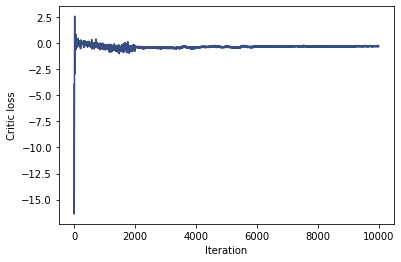

In [ ]:
plt.plot(D_losses,color = '#384d80')
plt.xlabel('Iteration')
plt.ylabel('Critic loss')
plt.show()

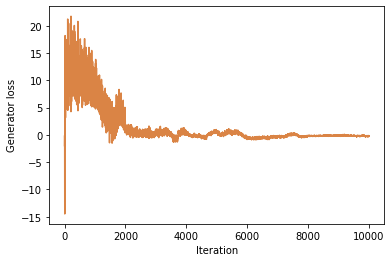

In [ ]:
plt.plot(G_losses,color = '#da8445')
plt.xlabel('Iteration')
plt.ylabel('Generator loss')
plt.show()

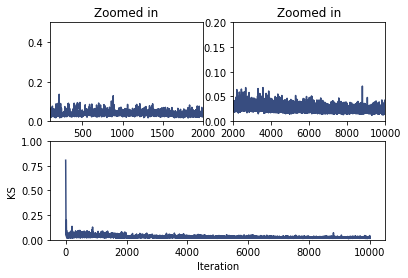

In [ ]:
ax1 = plt.subplot(221)
ax1.set_xlim(100,2000)
ax1.set_ylim(0,0.5)
ax1.plot(KS_value,color = '#384d80')

ax1.set_title('Zoomed in')

ax2 = plt.subplot(222)
ax2.set_xlim(2000,10000)
ax2.set_ylim(0,0.2)        
ax2.plot(KS_value,color = '#384d80')

ax2.set_title('Zoomed in')

ax3 = plt.subplot(212)
ax3.set_ylim(0,1)
ax3.plot(KS_value,color = '#384d80')

ax3.set_xlabel('Iteration')
ax3.set_ylabel('KS')
plt.show()

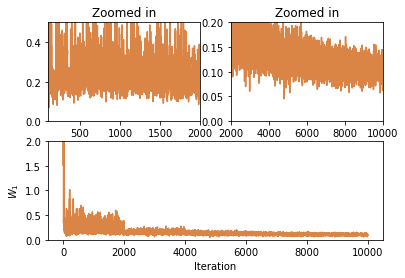

In [ ]:
ax1 = plt.subplot(221)
ax1.set_xlim(100,2000)
ax1.set_ylim(0,0.5)

ax1.plot(W_1,color = '#da8445')
ax1.set_title('Zoomed in')

ax2 = plt.subplot(222)
ax2.set_xlim(2000,10000)
ax2.set_ylim(0,0.2)        

ax2.plot(W_1,color = '#da8445')
ax2.set_title('Zoomed in')

ax3 = plt.subplot(212)
ax3.set_ylim(0,2)

ax3.plot(W_1,color = '#da8445')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('$W_1$')
plt.show()

**Test: distribution**

In [ ]:
testPara = {
    'npaths': 10000,
    'nsteps': 500,
    'ndepths': 10,
    'T': 500*0.1,
    'S0': 100,
    'mu': 0.05,
    'sigma': 1.0
}

test_dataset_parameters = {
    'modelpara': testPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}

In [ ]:
testdata = RealData(**test_dataset_parameters)

Jump intensity:  0.1


In [ ]:
test_GBM = testdata.generate_GBM(S0=100, npaths = 10000)
test_Monte_GBM = testdata.generate_Monte_GBM(test_GBM)
fitfunc = FitDistribution(
        generator,
        critic, 
        testPara,
        device)
GAN_Monte = fitfunc.fit(test_Monte_GBM)

In [ ]:
GAN_Monte.shape

(10000, 501, 10)

**The last timestep**

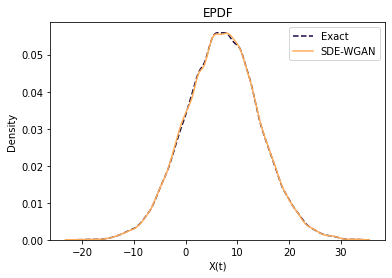

In [ ]:
sns.kdeplot(np.reshape(test_Monte_GBM[:,-1,:],-1), linestyle='--',label = 'Exact',color = '#1a0841')
sns.kdeplot(np.reshape(GAN_Monte[:,-1,:],-1), linestyle='-',label = 'SDE-WGAN',color = '#ffad5a')
plt.xlabel('X(t)')
plt.legend()
plt.title('EPDF')
plt.show()

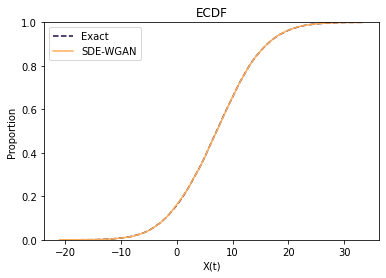

In [ ]:
sns.ecdfplot(np.reshape(test_Monte_GBM[:,-1,:],-1), linestyle='--',label = 'Exact',color = '#1a0841')
sns.ecdfplot(np.reshape(GAN_Monte[:,-1,:],-1), linestyle='-',label = 'SDE-WGAN',color = '#ffad5a')
plt.xlabel('X(t)')
plt.legend()
plt.title('ECDF')
plt.show()

In [ ]:
KS = sts.ks_2samp(np.reshape(test_Monte_GBM[:,-1,:],-1),
                  np.reshape(GAN_Monte[:,-1,:],-1))
W1 = wasserstein_distance(np.reshape(test_Monte_GBM[:,-1,:],-1),
                  np.reshape(GAN_Monte[:,-1,:],-1))
print('KS value %.6f' % KS[0])
print('KS p-value %.6lf' % KS[1])
print('W1 value %.6f' % W1)

KS value 0.002580
KS p-value 0.892423
W1 value 0.019779


**The first step**

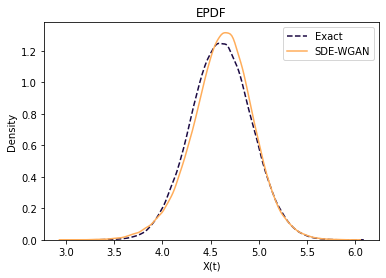

In [ ]:
sns.kdeplot(np.reshape(test_Monte_GBM[:,1,:],-1), linestyle='--',label = 'Exact',color = '#1a0841')
sns.kdeplot(np.reshape(GAN_Monte[:,1,:],-1), linestyle='-',label = 'SDE-WGAN',color = '#ffad5a')
plt.xlabel('X(t)')
plt.legend()
plt.title('EPDF')
plt.show()

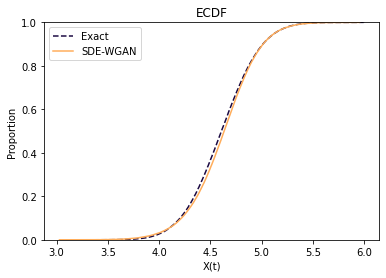

In [ ]:
sns.ecdfplot(np.reshape(test_Monte_GBM[:,1,:],-1), linestyle='--',label = 'Exact',color = '#1a0841')
sns.ecdfplot(np.reshape(GAN_Monte[:,1,:],-1), linestyle='-',label = 'SDE-WGAN',color = '#ffad5a')
plt.xlabel('X(t)')
plt.legend()
plt.title('ECDF')
plt.show()

In [ ]:
KS = sts.ks_2samp(np.reshape(test_Monte_GBM[:,1,:],-1),
                  np.reshape(GAN_Monte[:,1,:],-1))
W1 = wasserstein_distance(np.reshape(test_Monte_GBM[:,1,:],-1),
                  np.reshape(GAN_Monte[:,1,:],-1))
print('KS value %.6f' % KS[0])
print('KS p-value %.6lf' % KS[1])
print('W1 value %.6f' % W1)

KS value 0.036980
KS p-value 0.000000
W1 value 0.019976


In [ ]:
KSvalue = np.ones(testPara['nsteps'])
KSvalueP = np.ones(testPara['nsteps'])
W1 = np.ones(testPara['nsteps'])
for i in range(testPara['nsteps']):
    KSvalue[i] = sts.ks_2samp(np.reshape(test_Monte_GBM[:,i+1,:],-1),
                  np.reshape(GAN_Monte[:,i+1,:],-1))[0]
    KSvalueP[i] = sts.ks_2samp(np.reshape(test_Monte_GBM[:,i+1,:],-1),
                    np.reshape(GAN_Monte[:,i+1,:],-1))[1]
    W1[i] = wasserstein_distance(np.reshape(test_Monte_GBM[:,i+1,:],-1),
                  np.reshape(GAN_Monte[:,i+1,:],-1))


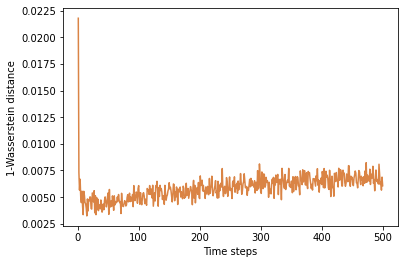

In [ ]:
x = np.linspace(1,500,500,dtype = int)
plt.plot(x,W1,color = '#da8445')
plt.ylabel('1-Wasserstein distance')
plt.xlabel('Time steps')
plt.show()

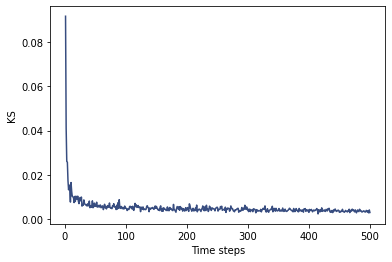

In [ ]:
x = np.linspace(1,500,500,dtype = int)
plt.plot(x,KSvalue,color = '#384d80')
plt.ylabel('KS')
plt.xlabel('Time steps')
plt.show()

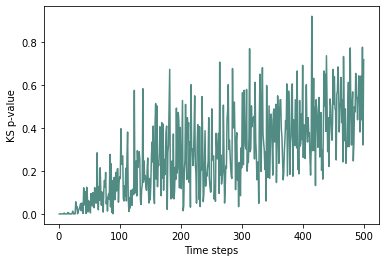

In [ ]:
x = np.linspace(1,500,500,dtype = int)
plt.plot(x,KSvalueP,color = '#518b83')
plt.ylabel('KS p-value')
plt.xlabel('Time steps')
plt.show()

### Jump-path simulation

In [ ]:
jump_elements = {
    'xiP': 1,
    'J': 1,
    'p': 0.5,
    'muJ': -0.2,
    'sigmaJ': 0.5
}
testjumpPara = {
    'npaths': 10000,
    'nsteps': 100,
    'ndepths': 10,
    'T': 100*0.1,
    'S0': 100,
    'mu': 0.05,
    'sigma': 0.2
}

testjump_dataset_parameters = {
    'modelpara': testjumpPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}

In [ ]:
testjumpdata = RealData(**testjump_dataset_parameters)

Jump intensity:  0.1


In [ ]:
test_GBM = testjumpdata.generate_GBM(S0=100, npaths = 10000)
test_jump,test_bernoulli, test_J = testjumpdata.generate_mertonJ_path(test_GBM)
test_Monte_GBM = testjumpdata.generate_Monte_GBM(test_GBM)
test_jump_monte = testjumpdata.generate_MontemertonJ(test_Monte_GBM,test_bernoulli, test_J)
fitfunc = FitDistribution(
        generator,
        critic, 
        testjumpPara,
        device)
monte_diffusion = np.zeros([testjumpPara['npaths'],testjumpPara['nsteps']+1,testjumpPara['ndepths']])
monte_diffusion[:,0,:] = test_jump_monte[:,0,:]
jump = test_bernoulli * test_J
for i in range(testjumpPara['nsteps']):
    monte_diffusion[:,i+1,:] = fitfunc.fitNextStep(monte_diffusion[:,i,:])

    for j in range(testjumpPara['ndepths']):
        monte_diffusion[:,i+1,j] = monte_diffusion[:,i+1,j] + jump[:,i]

    
   


Jump type: jumpType.mertonJ
Jump type: jumpType.mertonJ


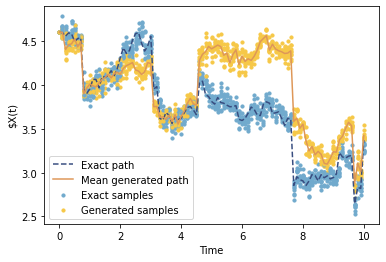

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(0,testjumpPara['T'],testjumpPara['nsteps']+1)
m = 100
for j in range(testjumpPara['ndepths']):
    ax.scatter(x,test_jump_monte[m,:,j], label = 'Exact samples',color = '#71aacd', s=10)
    ax.scatter(x,monte_diffusion[m,:,j], label = 'Generated samples',color = '#f6c848',s=10)


plt.plot(x,test_jump[m],label = 'Exact path',linestyle = '--', color = '#384d80')
plt.plot(x,np.mean(monte_diffusion[m],axis = 1),label = 'Mean generated path',color = '#de9758')

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[1],handles[2],handles[3]], 
          [labels[0],labels[1],labels[2],labels[3]],loc='best')

plt.ylabel('X(t)')
plt.xlabel('Time')
plt.show()

In [ ]:
weak_error = np.abs(np.mean(monte_diffusion[:,-1,:])-np.mean(test_jump_monte[:,-1,:]))
print(weak_error)

0.2799077953972686


In [ ]:
strong_error = np.mean(np.abs(monte_diffusion[:,-1,:]-test_jump_monte[:,-1,:]))
print(strong_error)

0.8238198347014019


### **Jump detection**

In [ ]:
class AnomalyDetection():
    def __init__(
        self,
        generator,
        critic, 
        testmodelpara,
        device
        ):
        self.generator = generator
        self.critic = critic
        self.device = device
        self.T = testmodelpara['T']
        self.S0 = testmodelpara['S0']
        self.dt = testmodelpara['T'] /float(testmodelpara['nsteps'])
        self.ndepths = testmodelpara['ndepths']
    
    def anomalyscore(self, npaths, nsteps, exactJumpPath, eta):
        length = npaths
        depth = self.ndepths
        width = nsteps
        score = np.zeros([length, width+1])
        R_loss = np.zeros([length, width])
        D_loss = np.zeros([length, width])
        patterns = np.zeros([length, width+1, depth])
        patterns[:,0,:] = np.log(self.S0)
        score[:,0] = 0
        dt = torch.torch.tensor(np.ones([1,depth]) * self.dt, 
                                dtype=torch.float32)
        dt = dt.to(self.device)
        for l in range(length):
            for i in range(width):
                z = np.random.normal(0.0, 1.0,[1, depth])
                z = torch.tensor(z,dtype=torch.float32).to(self.device)
                
                x0 = torch.tensor(np.ones([1,depth])*exactJumpPath[l,i], 
                                  dtype=torch.float32).to(self.device)
                realX = torch.tensor(np.ones([1,depth])* exactJumpPath[l,i+1],
                                     dtype=torch.float32).to(self.device)
                conditional_real_samples = torch.cat((realX,dt,x0),dim = -1)

                z_hat = Variable(z, requires_grad=True).to(self.device)
                opt = torch.optim.Adam([z_hat], lr=0.0001, betas=(0.5, 0.999))
            
                for j in range(50):
                    opt.zero_grad()
                    conditional_fake_latent_samples = torch.cat((z_hat,dt,x0),-1)
                    G_z= generator(conditional_fake_latent_samples)          
                    L_R = torch.linalg.norm(torch.mean(G_z,1)-realX,ord=1)
                    conditional_fake_samples = torch.cat((G_z,dt,x0),-1) 
                
                    L_D = torch.linalg.norm(critic(conditional_fake_samples).view(-1) 
                                - critic(conditional_real_samples).view(-1), ord = 1)
            
                    loss = (1-eta) * L_R + eta * L_D
                    
                    loss.backward()
                    opt.step()
                
                patterns[l,i+1] = G_z.cpu().detach().numpy()
                score[l,i+1] = loss.item()
                
                R_loss[l,i] = L_R.item()
                D_loss[l,i] = L_D.item()
        return score, R_loss, D_loss, patterns

    def anomalyAccurate(self, exactJumpPath, exactBernoulli, score, patterns, threshold):
       
        real_jump = np.nonzero(np.reshape( exactBernoulli,-1))[0] # position start at t0
        print('real jump place:')
        print(real_jump)
        print('---------------------------------')
        detected_jump = np.nonzero(np.reshape(score[:,1:],-1)-0.1>0)[0]
        print(detected_jump)


In [ ]:
jump_elements = {
    'xiP': 1,
    'J': 1,
    'p': 0.5,
    'muJ': 1.0,
    'sigmaJ': 0.5
}

jumpdetectPara = {
    'npaths': 5,
    'nsteps': 100,
    'ndepths': 10,
    'T': 100*0.1,
    'S0': 100,
    'mu': 0.05,
    'sigma': 0.2
}

detect_dataset_parameters = {
    'modelpara': jumpdetectPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **jump_elements)
}

In [ ]:
detectjumpdata = RealData(**detect_dataset_parameters)
test_GBM = detectjumpdata.generate_GBM(S0=100, npaths = 5)
real_jump, real_bernoulli, real_J = detectjumpdata.generate_mertonJ_path(test_GBM)

Jump intensity:  0.1
Jump type: jumpType.mertonJ


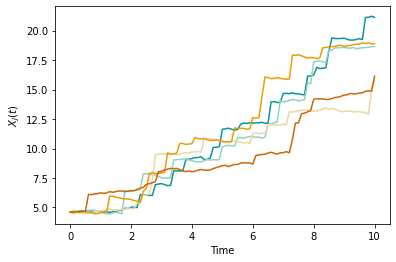

In [ ]:
colors = [ '#099496','#91d3c0','#ebd7a5','#ee9b00','#cc6602']
x = np.linspace(0,jumpdetectPara['T'],jumpdetectPara['nsteps']+1)
for i in range(jumpdetectPara['npaths']):
    plt.plot(x,real_jump[i],color = colors[i])
plt.xlabel('Time')
plt.ylabel('$X_J(t)$')
plt.show()

In [ ]:
anomaly_detector = AnomalyDetection(
                    generator,
                    critic,
                    jumpdetectPara,
                    device
                    )
score, R_loss, D_loss, patterns = anomaly_detector.anomalyscore(npaths = jumpdetectPara['npaths'],
                                                                nsteps = jumpdetectPara['nsteps'],
                                                                exactJumpPath = real_jump, 
                                                                eta=0.4)

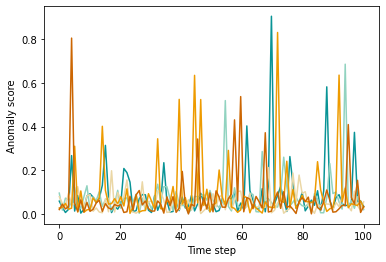

In [ ]:
anomalyscore = score[:,1:]
colors = ['#099496','#91d3c0','#ebd7a5','#ee9b00','#cc6602']
x = np.linspace(0,jumpdetectPara['nsteps'],jumpdetectPara['nsteps'])
for i in range(jumpdetectPara['npaths']):
    plt.plot(x,anomalyscore[i],color = colors[i])
plt.xlabel('Time step')
plt.ylabel('Anomaly score')
plt.show()

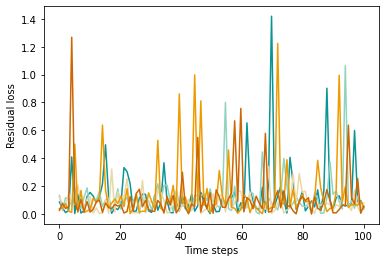

In [ ]:
colors = ['#099496','#91d3c0','#ebd7a5','#ee9b00','#cc6602']
x = np.linspace(0,jumpdetectPara['nsteps'],jumpdetectPara['nsteps'])
for i in range(jumpdetectPara['npaths']):
    plt.plot(x,R_loss[i],color = colors[i])
plt.xlabel('Time steps')
plt.ylabel('Residual loss')
plt.show()

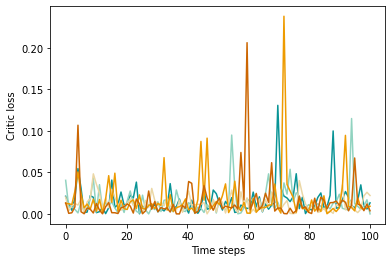

In [ ]:
colors = ['#099496','#91d3c0','#ebd7a5','#ee9b00','#cc6602']
x = np.linspace(0,jumpdetectPara['nsteps'],jumpdetectPara['nsteps'])
for i in range(jumpdetectPara['npaths']):
    plt.plot(x,D_loss[i],color = colors[i])
plt.xlabel('Time steps')
plt.ylabel('Critic loss')
plt.show()

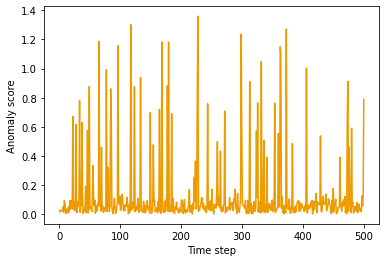

In [ ]:
anomalyscore = np.reshape(score[:,1:],-1)
colors = ['#099496','#91d3c0','#ebd7a5','#ee9b00','#cc6602']
x = np.linspace(0,jumpdetectPara['npaths'] * (jumpdetectPara['nsteps']),
                jumpdetectPara['npaths'] * (jumpdetectPara['nsteps']))
plt.plot(x,anomalyscore,color = colors[-2])
plt.xlabel('Time step')
plt.ylabel('Anomaly score')
plt.show()

In [ ]:
actual_jump_instance = np.nonzero(np.reshape(real_bernoulli,-1))[0]
print('actual jumps:', actual_jump_instance)

actual jumps: [ 22  27  33  37  43  46  49  55  65  69  77  80  84  85  96 117 123 133
 149 154 164 168 169 177 179 184 186 194 221 223 226 227 243 259 264 271
 298 299 312 323 324 325 331 335 340 353 359 362 363 372 382 405 424 428
 460 472 473 475 479 499]


In [ ]:
#threshold = 0.2

detected_jump_instance = np.nonzero(anomalyscore-0.2>0)[0]
print('detected jumps:', detected_jump_instance)

detected jumps: [ 22  27  33  37  46  49  55  65  69  77  80  84  85  96 117 123 133 149
 154 164 168 177 179 184 221 223 226 227 243 259 264 271 298 299 312 323
 325 331 335 340 353 359 362 363 372 382 405 428 460 472 473 475 479 499]


In [ ]:
true_detected_position = np.intersect1d(detected_jump_instance,
                                                 actual_jump_instance)
print('True detected jumps:', true_detected_position)

True detected jumps: [ 22  27  33  37  46  49  55  65  69  77  80  84  85  96 117 123 133 149
 154 164 168 177 179 184 221 223 226 227 243 259 264 271 298 299 312 323
 325 331 335 340 353 359 362 363 372 382 405 428 460 472 473 475 479 499]


In [ ]:
detected_number = len(detected_jump_instance)
true_number = len(true_detected_position)
total_jump = len(actual_jump_instance)
true_percentage = true_number /total_jump * 100

print('True negative rate: %.2f'% true_percentage,'%')

real_label = np.zeros(len(anomalyscore))
pred_label = np.zeros(len(anomalyscore))
pred_label[detected_jump_instance] = 1
real_label[actual_jump_instance] = 1

matrix = confusion_matrix(real_label,pred_label)
accuracy = (matrix[0][0]+matrix[1][1])/(matrix[0][0]+matrix[1][1]+matrix[0][1]+matrix[1][0]) * 100
precision = matrix[0][0]/(matrix[0][0]+matrix[1][0]) * 100
recall = matrix[0][0]/(matrix[0][0]+matrix[0][1]) * 100
F1 = 2 * precision * recall / (precision + recall)
print('confusion matrix:\n', matrix)
print('Accuracy: %.2f'% accuracy,'%')
print('Precision: %.2f'% recall,'%')
print('Recall: %.2f'% precision,'%')
print('F1 score: %.2f'% F1)

True negative rate: 90.00 %
confusion matrix:
 [[440   0]
 [  6  54]]
Accuracy: 98.80 %
Precision: 98.65 %
Recall: 100.00 %
F1 score: 99.32


**Jump parameter estimation**

In [ ]:
generated_pattern = np.reshape(patterns[:,1:,:], 
                                (jumpdetectPara['npaths'] * jumpdetectPara['nsteps'],
                                jumpdetectPara['ndepths'])) #size: [npaths * nsteps,ndepths]
generated_jump_place = generated_pattern[detected_jump_instance] #size: [num(jump),ndepths]
real_jump_place = np.reshape(real_jump[:,1:],-1)[detected_jump_instance] # size: num(jump)
previous_state = np.reshape(real_jump[:,1:],-1)[detected_jump_instance-1]
detected_jump_size = real_jump_place - np.mean(generated_jump_place,1)

#MertonJ paras
muJ_hat, sigmaJ_hat = norm.fit(detected_jump_size,method="MLE")
print('muJ: % .6f' % muJ_hat)
print('sigmaJ: %.6f'% sigmaJ_hat)

xidt = []
for i in range(jumpdetectPara['npaths']):
    es_xi = len(np.nonzero(score[i,1:]-0.15>0)[0])/np.nonzero(score[i,1:]-0.15>0)[0][-1]
    xidt.append(es_xi)
print('xi * dt: %.6f'% np.mean(xidt))
xi = np.mean(xidt)/0.1 #dt = 0.1
print('xi %.6f'%xi)

muJ:  1.192697
sigmaJ: 0.426563
xi * dt: 0.132876
xi 1.328758


**simulate the jump-diffusion path**

In [ ]:
estimatejump_elements = jump_elements
estimatejump_elements['xiP'] = xi
estimatejump_elements['muJ'] = muJ_hat
estimatejump_elements['sigmaJ'] = sigmaJ_hat
estimate_dataset_parameters = {
    'modelpara': jumpdetectPara,
    'jumptype': jumpType.mertonJ,
    'jumppara': set_jumppara(jumpType.mertonJ, **estimatejump_elements)
}

In [ ]:
estimatejumpdata = RealData(**estimate_dataset_parameters)
estimate_GBM = estimatejumpdata.generate_GBM(S0=100, npaths = 1000)
estimate_jump,_,_= estimatejumpdata.generate_mertonJ_path(estimate_GBM)

Jump intensity:  0.13287579629043045
Jump type: jumpType.mertonJ


In [ ]:
detectjumpdata = RealData(**detect_dataset_parameters)
test_GBM = detectjumpdata.generate_GBM(S0=100, npaths = 1000)
real_jump, real_bernoulli, real_J = detectjumpdata.generate_mertonJ_path(test_GBM)

Jump intensity:  0.1
Jump type: jumpType.mertonJ


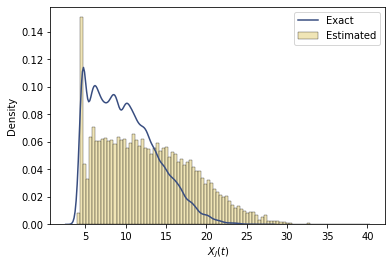

In [ ]:
sns.kdeplot(np.reshape(real_jump,-1),color = '#384d80',label = 'Exact')
sns.histplot(np.reshape(estimate_jump,-1),stat = 'density',color = '#ecdd9e',label = 'Estimated')
plt.xlabel('$X_J(t)$')
plt.legend()
plt.show()


In [ ]:
ks = sts.ks_2samp(np.reshape(real_jump,-1),np.reshape(estimate_jump,-1))
w1 = wasserstein_distance(np.reshape(real_jump,-1),np.reshape(estimate_jump,-1))
print('ks value %.6f' % ks[0])
print('ks p-value %.6f' % ks[1])
print('w1 %.6f' % w1)

ks value 0.046446
ks p-value 0.000000
w1 0.175523


In [ ]:
real_jump.shape

(1000, 101)

**anomaly score vs jump size (Future research)**

In [ ]:
x = range(jumpdetectPara['nsteps']*jumpdetectPara['npaths'])
abs_diff_paths = np.abs((np.mean(generated_pattern,1)-np.reshape(test_data['jumpX'][:,1:],-1)))
plt.plot(x,abs_diff_paths,'--k',label = 'Jump size')
plt.scatter(x,score[:,1:],color = 'red',label = 'Anomaly score')
plt.xlabel('Timesteps')
plt.legend(loc = 'upper left')
plt.show()

### S & P 500

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_data.SP500.csv to sample_data.SP500.csv


In [ ]:
stock_df = pd.read_csv(r'sample_data.SP500.csv')
print(stock_df)

                 Datetime         Open         High          Low        Close  \
0     2022-11-01 09:30:00  3901.790039  3911.790039  3901.790039  3909.000000   
1     2022-11-01 09:35:00  3908.629883  3911.610107  3903.850098  3907.699951   
2     2022-11-01 09:40:00  3907.879883  3910.679932  3905.040039  3906.270020   
3     2022-11-01 09:45:00  3906.439941  3906.449951  3891.120117  3893.570068   
4     2022-11-01 09:50:00  3893.590088  3893.689941  3887.719971  3889.439941   
...                   ...          ...          ...          ...          ...   
1598  2022-11-30 15:35:00  4064.770020  4068.600098  4059.189941  4060.969971   
1599  2022-11-30 15:40:00  4060.830078  4062.270020  4059.139893  4060.770020   
1600  2022-11-30 15:45:00  4061.030029  4064.080078  4060.320068  4062.540039   
1601  2022-11-30 15:50:00  4062.300049  4072.280029  4062.300049  4071.070068   
1602  2022-11-30 15:55:00  4071.030029  4078.810059  4068.800049  4078.770020   

        Adj Close     Volum

In [ ]:
# def get_stock_returns(stock_df):
#     prices = stock_df

In [ ]:
1/255

0.00392156862745098

In [ ]:
def get_stock_returns(ticker, start_date, end_date):
    stock_data_df = yf.download(ticker ,start = start_date, end = end_date, interval="1d") 
    stock_data_df = stock_data_df [['Close']]
    prices = stock_data_df['Close']
    returns = stock_data_df['Close'].pct_change() * 100
    return prices, returns.dropna()
start_date = "2010-01-01"
end_date = "2022-01-01"

df_SPX_prices, df_SPX_returns = get_stock_returns('^GSPC', start_date, end_date)

print('data size:', len(df_SPX_returns))

[*********************100%***********************]  1 of 1 completed
data size: 3020


In [ ]:
SPX_prices = df_SPX_prices.to_numpy()
SPX_prices = np.reshape(SPX_prices,(1,SPX_prices.size))
SPX_returns = df_SPX_returns.to_numpy()
SPX_returns = np.reshape(SPX_returns,(1,SPX_returns.size))
log_SPX_prices = np.log(SPX_prices)

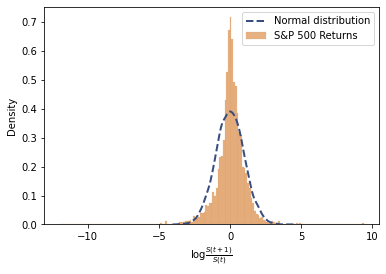

Kurtosis: 18.048132


In [ ]:
sns.histplot(np.reshape(SPX_returns,-1), stat = 'density', label = 'S&P 500 Returns', kde = False, color = '#de9758',edgecolor="#de9758")

normal_data = np.random.normal(size = 10000) # Standard normal distribution N(0,1)
sns.kdeplot(normal_data, label = 'Normal distribution',color = '#384d80', linestyle = '--', linewidth = 2)
plt.xlabel(r'$\log \frac{S(t+1)}{S(t)}$')
plt.legend()
plt.show()
#print('Date:', start_date, '--', end_date)
print('Kurtosis: %.6f' % sts.kurtosis(np.reshape(SPX_returns,-1),fisher=False))

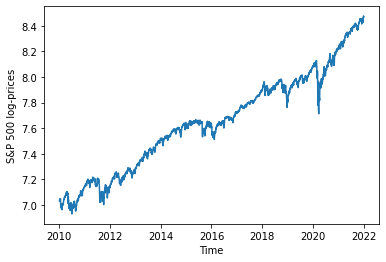

In [ ]:
plt.plot(np.log(df_SPX_prices))
plt.xlabel('Time')
plt.ylabel('S&P 500 log-prices')
plt.show()

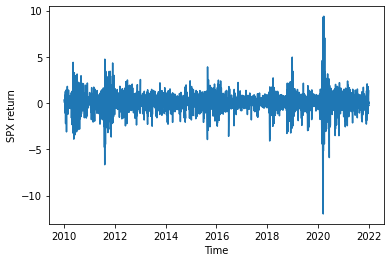

In [ ]:
plt.plot(df_SPX_returns)
plt.xlabel('Time')
plt.ylabel('SPX return')
plt.show()

In [ ]:
suspiciousJump = np.nonzero(np.reshape(np.abs(SPX_returns),-1)>0.3)[0]
print(suspiciousJump)
print('Num_jumps:', suspiciousJump.size)

[   0    2    5 ... 3013 3014 3015]
Num_jumps: 1907


In [ ]:
suspiciousNormal = np.delete(log_SPX_prices, suspiciousJump)
print(suspiciousNormal.size)

1114


In [ ]:
est_mu, est_sigma = sts.norm.fit(SPX_returns, method = 'MLE')
print('est_mu', est_mu)
print('est_sigma', est_sigma)

est_mu 0.05345917900742616
est_sigma 1.0814933954072723


In [ ]:
est_mu, est_sigma = sts.norm.fit(suspiciousNormal, method = 'MLE')
print('est_mu', est_mu)
print('est_sigma', est_sigma)

est_mu 7.669138675439407
est_sigma 0.3648916382605436


In [ ]:
#??????
delta_t = 0.004
sigma_hat = est_sigma / np.sqrt(delta_t)
mu_hat = (est_mu / delta_t) + est_sigma * est_sigma /2
print('mu_hat:', mu_hat)
print('sigma_hat', sigma_hat)

mu_hat: 1917.351241813688
sigma_hat 5.769443380267793


In [ ]:
SPXmodelPara = {
    'npaths': 10000,
    'nsteps': 30,
    'ndepths': 10,
    'T': 30*0.004,
    'S0': SPX_prices.mean(),
    'mu': est_mu,
    'sigma': est_sigma 
}

SPXjump_elements = {
    'xiP': 1,
    'J': 1,
    'p': 0.5,
    'muJ': 0.15,
    'sigmaJ': 0.11
}


In [ ]:
realdata = RealData(modelpara = SPXmodelPara,
                    jumptype = jumpType.mertonJ,
                    jumppara = set_jumppara(jumpType.mertonJ, **SPXjump_elements))
trainloader = realdata.build_trainloader(batch_size=100,
                                        S0 = SPX_prices.mean(), 
                                        npaths=2000)

Jump intensity:  0.004


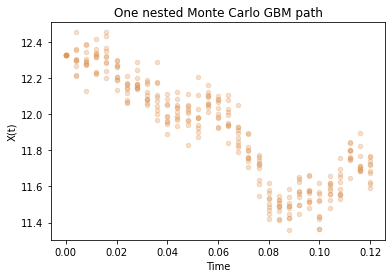

In [ ]:
# Test the trainloader
x = np.linspace(0,SPXmodelPara['T'],SPXmodelPara['nsteps']+1)
for MonteX in trainloader:
    for j in range(MonteX.shape[0]):
        for k in range(MonteX.shape[-1]):
            plt.scatter(x,MonteX[j,:,k]
                        ,s=20,alpha = 0.3,color = '#de9758')
        break
    break
plt.title('One nested Monte Carlo GBM path')
plt.xlabel('Time')
plt.ylabel('X(t)')    
plt.show()

In [ ]:
training_parameters = {
  'lr_step': 20,
  'lr_gamma': 0.3,
  'min_lr': 1e-08,
  'critic_iter': 9,
  'gp_lambda': 60,
  'latent_dim':SPXmodelPara['ndepths'],
  'model_para': SPXmodelPara,
  'device': device
}

generator_params = {
  "c_dim": 2 *SPXmodelPara['ndepths'],
  "input_dim": SPXmodelPara['ndepths'],
  "output_dim": SPXmodelPara['ndepths'], 
  "hidden_neurons": [100,100,100,100],
  "activation":nn.LeakyReLU(0.1)
}
critic_params = {
  "c_dim": 2 *SPXmodelPara['ndepths'], 
  "input_dim": SPXmodelPara['ndepths'],
  "output_dim": 1,
  "hidden_neurons":  [100,100,100,100],
  "activation":nn.LeakyReLU(0.1)
}

In [ ]:
generator = Generator(**generator_params).to(device)
critic = Critic(**critic_params).to(device)

lr = 0.0003
generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)


trainer = TrainDistribution(
  generator=generator,
  critic=critic, 
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  trainloader = trainloader,
  **training_parameters
)

D_losses, G_losses, Generated_results, KS_value, W_1 = trainer.trainingloop_withKS(nepochs=100)

Epoch 100: 100%|██████████| 100/100 [00:06<00:00, 15.15batch/s, avg_D_loss=0.00137, avg_G_loss=-9.53]


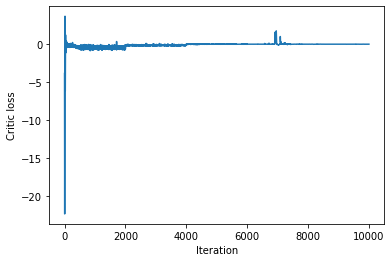

In [ ]:
plt.plot(D_losses)
plt.xlabel('Iteration')
plt.ylabel('Critic loss')
plt.show()

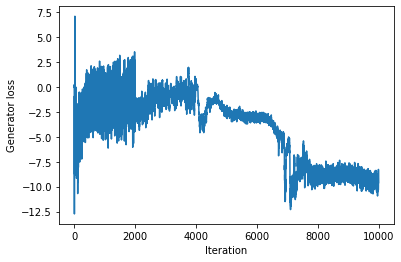

In [ ]:
plt.plot(G_losses)
plt.xlabel('Iteration')
plt.ylabel('Generator loss')
plt.show()

In [ ]:
test_GBM = realdata.generate_GBM(S0=SPX_prices.mean(), npaths = 10000)
test_Monte_GBM = realdata.generate_Monte_GBM(test_GBM)

In [ ]:
fitfunc = FitDistribution(
        generator,
        critic, 
        SPXmodelPara,
        device)
GAN_Monte = fitfunc.fit(test_Monte_GBM)

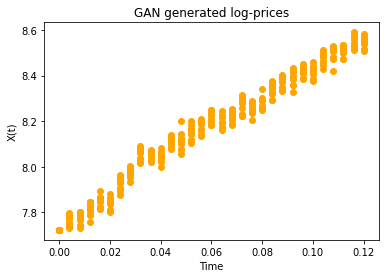

In [ ]:
x = np.linspace(0,SPXmodelPara['T'],SPXmodelPara['nsteps']+1)
for k in range(SPXmodelPara['ndepths']):
    plt.scatter(x,GAN_Monte[1,:,k], color = 'orange')
plt.title('GAN generated log-prices')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.show()

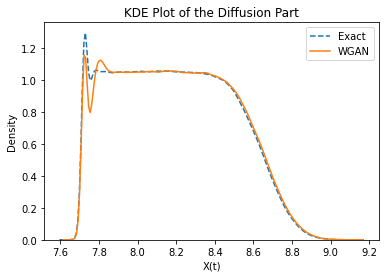

In [ ]:
sns.kdeplot(np.reshape(test_Monte_GBM,-1), linestyle='--',label = 'Exact')
sns.kdeplot(np.reshape(GAN_Monte,-1), linestyle='-',label = 'WGAN')
plt.xlabel('X(t)')
plt.legend()
plt.title('KDE Plot of the Diffusion Part')
plt.show()

In [ ]:
Q = np.reshape(test_Monte_GBM,-1)
P = np.reshape(GAN_Monte,-1)
print('KL:',sum(rel_entr(P, Q)))
print('JS:',distance.jensenshannon(P,Q))
print('W:',wasserstein_distance(P,Q))

KL: 23002.60714788225
JS: 0.0018148588413002154
W: 0.007309025094166056


In [ ]:
anomaly = AnomalyDetection(generator,
                            critic, 
                            SPXmodelPara,
                            device)
anomalyscore, as_R_loss, as_D_loss, as_patterns = anomaly.anomalyscore(npaths = 1, nsteps =SPX_prices.shape[1]-1, 
                                                                       exactJumpPath = log_SPX_prices, eta=0.5)

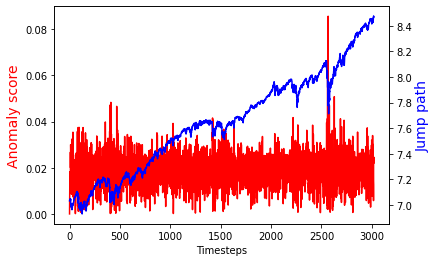

In [ ]:

fig,ax = plt.subplots()
ax.plot(np.transpose(anomalyscore),
        color="red")
ax.set_xlabel("Timesteps", fontsize = 10)
ax.set_ylabel("Anomaly score",
              color="red",
              fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(np.transpose(log_SPX_prices),color="blue")
ax2.set_ylabel("Jump path",color="blue",fontsize=14)
plt.show()

In [ ]:
detected_jump = np.nonzero(np.reshape(anomalyscore[:,1:],-1)-0.03>0)[0]
print(detected_jump)
print('No. jumps:', len(detected_jump))

[  21   33   77   84   94  101  121  133  141  157  159  160  169  214
  218  269  297  301  347  349  354  364  381  393  397  399  401  403
  409  414  424  432  433  437  439  440  444  467  473  475  477  546
  573  588  607  621  643  665  687  815  866  870  917  962  968 1005
 1012 1026 1037 1074 1097 1153 1189 1256 1258 1266 1273 1416 1417 1418
 1424 1442 1478 1488 1489 1509 1512 1516 1525 1529 1547 1553 1572 1584
 1629 1630 1671 1701 1884 1908 1913 2035 2051 2067 2073 2077 2207 2215
 2217 2219 2235 2242 2253 2258 2264 2280 2318 2349 2353 2366 2411 2416
 2418 2452 2487 2549 2550 2551 2553 2556 2558 2559 2560 2562 2563 2565
 2567 2569 2570 2574 2577 2579 2589 2590 2598 2605 2606 2626 2635 2637
 2655 2687 2689 2696 2698 2723 2730 2773 2784 2786 2809 2857 2953 2957
 2997 2998 3000 3006 3011]
No. jumps: 159


In [ ]:
position = np.intersect1d(detected_jump,suspiciousJump)
print('Detected jump place:', position)
detect_result = np.in1d(detected_jump,suspiciousJump)

true_number = np.count_nonzero(detect_result)
true_percentage = true_number /len(suspiciousJump) * 100
false_percentage = (len(detected_jump)-true_number)/len(suspiciousJump) * 100

print('Accuracy: %.2f'% true_percentage,'%')

print('False detected: %.2f'% false_percentage,'%')
real_label = np.zeros(len(np.reshape(anomalyscore[:,1:],-1)))
pred_label = np.zeros(len(np.reshape(anomalyscore[:,1:],-1)))
pred_label[detected_jump-1] = 1
real_label[suspiciousJump-1] = 1

Detected jump place: [  21   33   77   84   94  101  121  133  141  157  159  160  169  214
  269  297  301  347  354  364  381  393  397  399  401  403  409  414
  424  432  433  437  439  440  444  467  473  475  477  546  573  588
  607  621  643  665  687  815  866  870  917  962  968 1005 1012 1026
 1037 1074 1097 1153 1189 1256 1258 1266 1273 1416 1417 1418 1424 1442
 1488 1489 1509 1512 1516 1525 1529 1547 1553 1572 1584 1629 1630 1671
 1884 1913 2035 2051 2067 2073 2077 2207 2215 2217 2219 2235 2253 2258
 2264 2280 2318 2349 2353 2366 2411 2416 2418 2452 2487 2549 2550 2551
 2553 2556 2558 2559 2560 2562 2563 2565 2567 2569 2570 2574 2577 2579
 2589 2590 2598 2605 2606 2626 2635 2637 2655 2687 2689 2696 2698 2723
 2773 2784 2786 2809 2857 2953 2957 2997 2998 3000 3006 3011]
Accuracy: 7.97 %
False detected: 0.37 %


In [ ]:
generated_pattern = np.reshape(as_patterns[:,1:,:], 
                                (1*as_patterns[:,1:,:].shape[1],
                                10))
generated_jump_place = generated_pattern[detected_jump]
real_jump_place = np.reshape(log_SPX_prices,-1)[detected_jump] # size: num(jump)
detected_jump_size = real_jump_place - np.mean(generated_jump_place,1)

#MertonJ paras
muJ_hat, sigmaJ_hat = norm.fit(detected_jump_size,method="MLE")
print('muJ: % .6f' % muJ_hat)
print('sigmaJ: %.6f'% sigmaJ_hat)
xidt = len(detected_jump)/detected_jump[-1]
print('xi * dt: %.6f'% xidt)

muJ: -0.047288
sigmaJ: 0.008939
xi * dt: 0.052806


In [ ]:
est_SPXjump_elements = {
    'xiP': xidt/delta_t,
    'J': 1,
    'p': 0.5,
    'muJ': muJ_hat,
    'sigmaJ': sigmaJ_hat
}

SPXdistributionPara = {
    'npaths': 10000,
    'nsteps': 30,
    'ndepths': 10,
    'T': 30*0.004,
    'S0': SPX_prices.mean(),
    'mu': est_mu,
    'sigma': est_sigma 
}


In [ ]:
jumpDistributionData = RealData(modelpara = SPXdistributionPara,
                        jumptype = jumpType.mertonJ,
                        jumppara = set_jumppara(jumpType.mertonJ, **est_SPXjump_elements))
basicGBM = jumpDistributionData.generate_GBM(S0 = SPX_prices[:,0], npaths = 1000)
mertonDistribution,\
MertonBernoulli, \
MertonJump = jumpDistributionData.generate_mertonJ_path(basicGBM)

Jump intensity:  0.052806376619063435
Jump type: jumpType.mertonJ


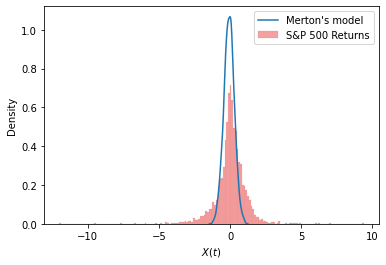

Merton Kurtosis: 2.9676382927463134
S&P Kurtosis: 18.048132111605092


In [ ]:

log_returns = mertonDistribution[:,-1]-mertonDistribution[:,0]
#sns.histplot(log_returns, stat = 'density', label = 'Merton\'s model', kde = False, color = 'gold')
sns.histplot(np.reshape(SPX_returns,-1), stat = 'density', label = 'S&P 500 Returns', kde = False, color = 'lightcoral',edgecolor="lightcoral")
sns.kdeplot(log_returns,label = 'Merton\'s model')
#normal_data = np.random.normal(size = 10000) # Standard normal distribution N(0,1)
#sns.kdeplot(normal_data, label = 'Normal distribution',color = 'black', linestyle = '--', linewidth = 2)
plt.legend()
plt.xlabel('$X(t)$')
plt.show()
print('Merton Kurtosis:', sts.kurtosis(log_returns,fisher=False))
print('S&P Kurtosis:', sts.kurtosis(np.reshape(SPX_returns,-1),fisher=False))

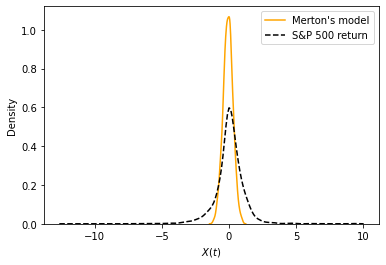

In [ ]:
sns.kdeplot(log_returns,label = 'Merton\'s model', color = 'orange')
sns.kdeplot(np.reshape(SPX_returns,-1),label = 'S&P 500 return',linestyle = '--',color = 'black')
plt.xlabel('$X(t)$')
plt.legend()
plt.show()

In [ ]:
def get_monthly_stock_returns(ticker, start_date, end_date):
    stock_data_df = yf.download(ticker ,start = start_date, end = end_date, interval="1mo") 
    stock_data_df = stock_data_df [['Close']]
    prices = stock_data_df['Close']
    returns = stock_data_df['Close'].pct_change() * 100
    return prices, returns.dropna()
start_date = "2020-10-01"
end_date = "2021-11-01"

test_SPX_prices, test_SPX_returns = get_monthly_stock_returns('^GSPC', start_date, end_date)
print('test size:', len(test_SPX_returns))

[*********************100%***********************]  1 of 1 completed
test size: 12


In [ ]:
test_SPX_prices

Date
2020-10-01    3269.959961
2020-11-01    3621.629883
2020-12-01    3756.070068
2021-01-01    3714.239990
2021-02-01    3811.149902
2021-03-01    3972.889893
2021-04-01    4181.169922
2021-05-01    4204.109863
2021-06-01    4297.500000
2021-07-01    4395.259766
2021-08-01    4522.680176
2021-09-01    4307.540039
2021-10-01    4605.379883
Name: Close, dtype: float64

In [ ]:
test_SPX_prices = test_SPX_prices.to_numpy()
test_SPX_prices = np.reshape(test_SPX_prices,(1,test_SPX_prices.size))
test_SPX_returns = test_SPX_returns.to_numpy()
test_SPX_returns = np.reshape(test_SPX_returns,(1,test_SPX_returns.size))
test_log_SPX_prices = np.log(test_SPX_prices)

In [ ]:
est_SPX_pathPara = {
    'npaths': 1,
    'nsteps': 11,
    'ndepths': 10,
    'T': 11*0.01,
    'S0': test_SPX_prices[:,0],
    'mu': mu_hat,
    'sigma': sigma_hat 
}

Jump intensity:  0.058679706601466985
Jump type: jumpType.mertonJ


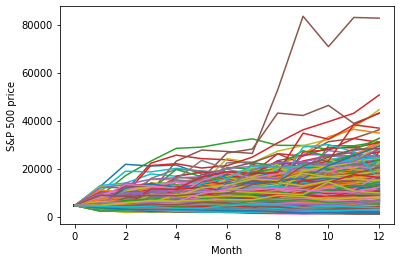

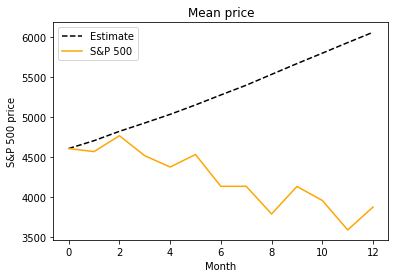

In [ ]:
jumpPathData = RealData(modelpara = est_SPX_pathPara,
                        jumptype = jumpType.mertonJ,
                        jumppara = set_jumppara(jumpType.mertonJ, **est_SPXjump_elements))
basicGBMPath = jumpPathData.generate_GBM(S0 = test_SPX_prices[:,0], npaths = est_SPX_pathPara['npaths'])
mertonPath,\
MertonPathBernoulli, \
MertonPathJump = jumpPathData.generate_mertonJ_path(basicGBMPath)
plt.plot(np.transpose(np.exp(mertonPath)))
plt.xlabel('Month')
plt.ylabel('S&P 500 price')
plt.show()

plt.plot(np.mean(np.transpose(np.exp(mertonPath)),axis = 1),linestyle = '--',color = 'black', label = 'Estimate')
plt.plot(np.transpose(test_SPX_prices),label = 'S&P 500', color = 'orange')
plt.legend()
plt.xlabel('Month')
plt.ylabel('S&P 500 price')
plt.title('Mean price')
plt.show()

In [ ]:
est_SPX_pathPara = {
    'npaths': 10000,
    'nsteps': 12,
    'ndepths': 10,
    'T': 12*0.01,
    'S0': test_SPX_prices[:,0],
    'mu': mu_hat,
    'sigma': sigma_hat 
}

NameError: ignored

In [ ]:
testfitfunc = FitDistribution(
        generator,
        critic, 
        est_SPX_pathPara,
        device)
testGAN_Monte = testfitfunc.GBM_fit(test_log_SPX_prices)
mean_test_GBM = np.mean(testGAN_Monte,axis = 2)

testjumpPathData = RealData(modelpara = est_SPX_pathPara,
                        jumptype = jumpType.mertonJ,
                        jumppara = set_jumppara(jumpType.mertonJ, **est_SPXjump_elements))

testmertonPath,\
testMertonPathBernoulli, \
testMertonPathJump = testjumpPathData.generate_mertonJ_path(mean_test_GBM)

x = np.linspace(0,testGAN_Monte.shape[1],testGAN_Monte.shape[1])
for k in range(testGAN_Monte.shape[-1]):
    plt.scatter(x, np.exp(np.mean(testGAN_Monte[:,:,k],axis = 0)),color = 'orange')
plt.plot(x, np.transpose(test_SPX_prices),label = 'S&P 500', color = 'black', linestyle = '--')
plt.plot(x, np.mean(np.exp(testmertonPath),axis = 0),label = 'Mean path', color = 'darkgoldenrod')
plt.legend()
plt.xlabel('Month')
plt.ylabel('S&P 500 price')
plt.show()

NameError: ignored

## **Old Version**

**Gradient Penalty**

$\hat{x} = \eta x +(1-\eta) \tilde{x}, \eta \sim U(0,1)$

Gradient penalty term: $ λ(||∇_{|\hat{x}|} C_w(\hat{x})||-1)^2$

In [ ]:
def calculate_gradient_penalty(critic, 
                               batch_size, 
                               real_samples, 
                               fake_samples, 
                               lambda_term):
    
    eta = torch.FloatTensor(batch_size,1).uniform_(0,1)
    eta = eta.expand(batch_size, real_samples.size(1))
    eta = eta.to(device)

    interpolated = (eta * real_samples \
                    + ((1 - eta) * fake_samples)).to(device)

    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = critic(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs = prob_interpolated, 
                              inputs = interpolated,
                              grad_outputs = torch.ones(
                                prob_interpolated.size()).to(device),
                              create_graph = True, 
                              retain_graph = True)[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_term
    return grad_penalty

The jump process under ℙ-measure: d X(t) = μ dt + σ dW(t) + J d $X_p$(t)


---


GAN learns the GBM part: x(t+1) = x(t) + μ Δt + σ W(t) 




In [ ]:


class jumpType(enum.Enum):
    fixJ = 1.0
    mertonJ = -1.0

In [ ]:
# exact dataset
def real_data(npaths,nsteps,ndepths,S0,mu,sigma,T,jump_para,jumptype):
    dt = T / float(nsteps)
    X0 = np.log(S0)

    print("Jump intensity: ",dt * jump_para['xiP'] )
    if dt * jump_para['xiP'] > 1:
        raise TypeError("Wrong jump setting parameters: jump intensity should not be larger than 1!")
    
    jump_X = np.zeros([npaths,nsteps+1])
    GBM_X = np.zeros([npaths,nsteps+1])
    Monte_GBM_X = np.zeros([npaths,nsteps+1,ndepths])
    Bernoulli = np.random.binomial(1, jump_para['xiP'] * dt, [npaths,nsteps])
    Z = np.random.normal(0.0, 1.0, [npaths,nsteps])
    Monte_Z = np.random.normal(0.0, 1.0, [npaths,nsteps,ndepths])
    GBM_X[:,0] = X0 # Suppose no jump occurs at t0
    jump_X[:,0] = X0 
    Monte_GBM_X[:,0] = X0

    for i in range(nsteps):
        # Make sure that samples from a normal have mean 0 and variance 1
        # if npaths > 1:
        #         Z[:,i] = (Z[:,i]-np.mean(Z[:,i]))/np.std(Z[:,i])  
        

        # Generate the main GBM path
        GBM_X[:,i+1] = GBM_X[:,i] + mu* dt + sigma * np.sqrt(dt) * Z[:,i]
        
        for j in range(npaths):
            # if ndepths > 1:
            #     Monte_Z[j,i,:] = (Monte_Z[j,i,:] - np.mean(Monte_Z[j,i,:]))/ np.std(Monte_Z[j,i,:])
            Monte_GBM_X[j,i+1,:] = GBM_X[j,i] + mu* dt + sigma * np.sqrt(dt) * Monte_Z[j,i,:]
    GBM_S = np.exp(GBM_X)
    Monte_GBM_S = np.exp(Monte_GBM_X)

# add jumps
    jump_X = np.zeros([npaths,nsteps+1])
    testjump_X = np.zeros([npaths,nsteps+1])
    jump_X[:,0] = X0
    testjump_X[:,0] = X0
    if jumptype == jumpType.fixJ:
        print("jumptype: fixJ")
        U = np.random.uniform(0,1,[npaths,nsteps])
        J = np.zeros([npaths,nsteps])
        for i in range(npaths):
            for j in range(nsteps):
                if U[i,j] >= jump_para['p']:
                    J[i,j] = jump_para['J'] 
                else:
                    J[i,j] = -jump_para['J'] 
        print(J* Bernoulli)
        test = J* Bernoulli
        test1 = np.cumsum(test,axis = 1)
        for i in range(nsteps): 
            jump_X[:,i+1] = jump_X[:,i] + mu* dt + sigma * np.power(dt, 0.5) * Z[:,i] + J[:,i]* Bernoulli[:,i]
            testjump_X[:,i+1] = GBM_X[:,i+1] + test1[:,i]
    if jumptype == jumpType.mertonJ:
        print('jumptype: MertonJ')
        J = np.random.normal(jump_para['muJ'], jump_para['sigmaJ'], [npaths,nsteps])
        for i in range(nsteps):
            #jump_X[:,i+1] = jump_X[:,i] + mu* dt + sigma * np.power(dt, 0.5) * Z[:,i]+ J[:,i] * Bernoulli[:,i]

            jump_X[:,i+1] = GBM_X[:,i+1] + J[:,i] * Bernoulli[:,i]
    jump_S = np.exp(jump_X)
    data = dict(GBMX = GBM_X, MonteGBMX = Monte_GBM_X, GBMS = GBM_S, MonteGBMS = Monte_GBM_S,
                jumpX = jump_X, jumpS = jump_S, testJumpX = testjump_X,
                Z = Z, J=J, Bernoulli = Bernoulli, MonteZ = Monte_Z)
    return(data)





Test real_data function:

(How to draw a better piture with gradient colors?)

Jump intensity:  0.1
jumptype: fixJ
[[-0.  -0.   0.  -0.  -0.  -0.   0.   0.   0.   0.  -0.   0.   0.5 -0.
  -0.  -0.  -0.  -0.  -0.  -0.   0.  -0.  -0.  -0.   0.   0.  -0.5  0.
  -0.   0.   0.   0.  -0.  -0.   0.  -0.  -0.   0.  -0.   0.   0.   0.
  -0.  -0.  -0.  -0.   0.   0.   0.   0.5 -0.  -0.  -0.   0.  -0.  -0.
  -0.  -0.   0.  -0.   0.   0.  -0.  -0.  -0.  -0.  -0.   0.  -0.  -0.
  -0.5  0.  -0.   0.  -0.  -0.  -0.  -0.  -0.  -0.   0.  -0.  -0.   0.
  -0.   0.  -0.  -0.   0.   0.  -0.  -0.   0.  -0.   0.  -0.  -0.   0.
   0.   0. ]
 [ 0.5  0.5  0.  -0.5  0.   0.  -0.   0.   0.   0.  -0.   0.  -0.5  0.
  -0.   0.   0.   0.  -0.  -0.  -0.  -0.   0.  -0.  -0.  -0.   0.   0.5
  -0.  -0.  -0.  -0.  -0.   0.   0.   0.  -0.  -0.  -0.   0.  -0.   0.5
  -0.   0.  -0.  -0.  -0.5  0.   0.   0.   0.   0.   0.   0.  -0.   0.
   0.  -0.   0.  -0.   0.  -0.   0.  -0.   0.  -0.  -0.  -0.  -0.  -0.
   0.  -0.5  0.   0.  -0.5 -0.   0.  -0.   0.   0.5 -0.  -0.5  0.  -0.
  -0.5  0.  -0.   0.5  0. 

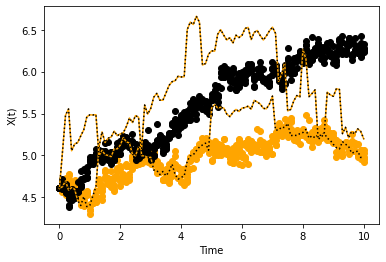

In [ ]:
fix_jump_para = dict(xiP = 1, J = 0.5, p = 0.5)

model_para = dict(npaths = 2,nsteps = 100,ndepths = 5,S0 = 100,mu = 0.05,sigma = 0.2,T = 10)
data = real_data(model_para['npaths'],model_para['nsteps'],model_para['ndepths'],
                 model_para['S0'],model_para['mu'],model_para['sigma'],model_para['T'],
                 jump_para=fix_jump_para,jumptype=jumpType.fixJ)

ax = plt.axes()
ax.set_facecolor('white')
color = ['orange','black']
#coloridx = plt.cm.ocean(np.linspace(0, 1, model_para['npaths']))
#cm = plt.cm.get_cmap('RdYlBu')
x = np.linspace(0,model_para['T'],model_para['nsteps']+1)
if model_para['ndepths'] > 1:
    for j in range(model_para['npaths']):
        for k in range(model_para['ndepths']):
            plt.scatter(x,data['MonteGBMX'][j,:,k],color = color[j]) 
for j in range(model_para['npaths']):
    if model_para['nsteps'] >1:
        plt.plot(x,data['jumpX'][j],color = 'orange',linestyle = '-')       
        plt.plot(x,data['testJumpX'][j],color = 'black',linestyle = ':')
            
            
    else:
        plt.scatter(x,data['GBMX'][j],marker = 'o')
        #plt.scatter(x,data['jumpX'][j],marker = '*') #,color = str(coloridx[j])
plt.xlabel('Time')
plt.ylabel('X(t)')   
plt.show()


**Train dataloader**

In [ ]:
def trainloader(batch_size,model_para,jump_para, jumptype):
    eps = 1e-6
    paths =int( model_para['npaths']/5)
    initialS0 = [int(model_para['S0']/100),int(model_para['S0']/10),model_para['S0'],int(model_para['S0']*10),int(model_para['S0']*100)] #
    MonteX = np.zeros([model_para['npaths'],model_para['nsteps']+1,model_para['ndepths']])
    X = np.zeros([model_para['npaths'],model_para['nsteps']+1])
    for l in range(5):
        data = real_data(paths,model_para['nsteps'],model_para['ndepths'],
                    initialS0[l],model_para['mu'],model_para['sigma'],model_para['T'],
                    jump_para=jump_para,jumptype=jumptype)
        MonteX[paths*l: paths*(l+1),:,:] = data['MonteGBMX']
        X[paths*l: paths*(l+1),:] = data['GBMX']
    X = torch.tensor(X,dtype=torch.float32)
    
    MonteX = torch.tensor(MonteX,dtype=torch.float32)       
   
    
    # X = torch.tensor(data['GBMX'],dtype=torch.float32)
    
    # MonteX = torch.tensor(data['MonteGBMX'] ,dtype=torch.float32)

    data = TensorDataset(MonteX,X) 
    train_loader = DataLoader(data,batch_size=batch_size, shuffle=True)
 
    return train_loader
    

In [ ]:
# Test trainloader function:

fix_jump_para = dict(xiP = 1, J = 1, p = 0.5)
model_para = dict(npaths = 10000,nsteps = 10,ndepths = 20,S0 = 100,mu = 0.05,sigma = 0.2,T = 1)
traindata = trainloader(batch_size = model_para['npaths'],model_para = model_para,jump_para = fix_jump_para, jumptype = jumpType.fixJ)
x = np.linspace(0,model_para['T'],model_para['nsteps']+1)
for MonteX, GBMX in traindata:
    
    for j in range(model_para['npaths']):
        for k in range(model_para['ndepths']):
            plt.scatter(x,MonteX[j,:,k],s=10,alpha = 0.3)
        #plt.plot(x,GBMX[j])
    # for i in range(model_para['nsteps']):
    #     plt.imshow(MonteX[:,i,:],
    #        vmin=0,
    #        vmax=1, 
    #        cmap=plt.get_cmap('hot'),
    #        interpolation='lanczos',
    #        aspect='auto'
    #        )

    #plt.plot(x,torch.transpose(GBMX,0,1))
    
plt.show()

**Training**

In [ ]:
# Method 1: fake_samples: E[G_z]

def train_distribution(C_hyper, G_hyper, model_para, jump_para, jumptype, batch_size, nepochs, critic_iter,learning_rate,lr_step,lr_gamma,min_lr,gp_lambda):
    

    critic = Critic(**C_hyper).to(device)
    generator = Generator(**G_hyper).to(device)

    optimizer_critic = torch.optim.RMSprop(critic.parameters(), lr=learning_rate)
    optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=learning_rate)
    critic_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_critic, step_size = lr_step, gamma = lr_gamma)
    generator_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size = lr_step, gamma = lr_gamma)

    D_losses = []
    G_losses = []
    Generated_results = []
    # torch.manual_seed(0)
    # np.random.seed(seed=0)
    train_loader = trainloader(batch_size,model_para,jump_para, jumptype)
    latent_dim = model_para['ndepths']

    for epoch in range(nepochs):
        D_loss_acc = 0
        G_loss_acc = 0

        critic.train()
        generator.train()
        progress_bar = tqdm(train_loader, unit="batch")
       
        for i,[MonteXt,Xt] in enumerate(progress_bar):
    
            Xt = Xt.to(device)  
            MonteXt = MonteXt.to(device)
            
            indices = np.random.randint(model_para['nsteps'])

            X0 = np.log(model_para['S0'])
            x0 = torch.torch.tensor(np.ones([Xt.size(0),latent_dim])*X0, dtype=torch.float32) #latent_dim
            x0 = x0.to(device)

            critic_x0 = torch.torch.tensor(np.ones([Xt.size(0),1])*X0, dtype=torch.float32)
            critic_x0 = critic_x0.to(device)

            delta_t = model_para['T']/float(model_para['nsteps'])
            dt = torch.tensor(np.ones([Xt.size(0),latent_dim])*delta_t, dtype=torch.float32)
            dt = dt.to(device)
        
            
            Monte_X0 = MonteXt[:,indices,:]
            Monte_X0 = Monte_X0.to(device)
            real_X0 = Xt[:,indices].view(-1,1)
            real_X0 = real_X0.to(device)
            real_Monte_Xt = MonteXt[:,indices+1,:] #.view(-1,1)
           
            real_Monte_Xt = real_Monte_Xt.to(device)

            real_Xt = Xt[:,indices+1].view(-1,1)
            real_Xt = real_Xt.to(device)


            for p in critic.parameters():
                p.requires_grad = True
            #print('batch_size:',Xt.size(0))

            # Training the discriminator
            for iter in range(critic_iter):

                # initialize latent variable z from 1-dim N(0,1)
                z = np.random.normal(0.0, 1.0,[Xt.size(0),latent_dim])
                z = torch.tensor(z,dtype=torch.float32)
                z = z.to(device) 
 
                conditional_real_samples = torch.cat((real_Monte_Xt,dt,Monte_X0),-1) #x0
                conditional_fake_latent_samples = torch.cat((z,dt,Monte_X0),-1) #x0
                
                G_z = generator(conditional_fake_latent_samples)
                mean_fake_samples = torch.mean(G_z,1,True)
                #print(mean_fake_samples.size())

                conditional_fake_samples = torch.cat((G_z,dt,Monte_X0),-1) #x0,

                
                critic.zero_grad()
                
                # Add gradient penalty
                gradient_penalty = calculate_gradient_penalty(critic, Xt.size(0),conditional_real_samples,conditional_fake_samples,gp_lambda) #latent_dim
                gradient_penalty.backward(retain_graph=True)

                loss_D = critic(conditional_fake_samples).mean() - critic(conditional_real_samples).mean() + gradient_penalty
                loss_D.backward(retain_graph=True)
                optimizer_critic.step()

                D_loss_acc += loss_D.item()

            # Training the generator

            z = np.random.normal(0.0, 1.0,[Xt.size(0),latent_dim])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,Monte_X0),-1) #x0,
            # print(conditional_fake_latent_samples.size())
            for p in critic.parameters():
                p.requires_grad = False

            generator.zero_grad()
            G_z = generator(conditional_fake_latent_samples)

            # save the generated result: X(t+1)
            generated_pattern = G_z.cpu().detach().numpy()
            Generated_results.append(generated_pattern)

            mean_fake_samples = torch.mean(G_z,1,True)
            conditional_fake_samples = torch.cat((G_z,dt,Monte_X0),-1) #x0,
            loss_G = - critic(conditional_fake_samples).mean()
            loss_G.backward()
            optimizer_generator.step()
            
            G_loss_acc += loss_G.item()  
                
            progress_bar.set_description(f"Epoch {epoch+1}")
            progress_bar.set_postfix(avg_D_loss=D_loss_acc / (i*critic_iter+1), avg_G_loss=G_loss_acc / (i+1))

            D_losses.append(loss_D.item())
            G_losses.append(loss_G.item()) 
        if generator_scheduler.get_last_lr()[0] > min_lr:
            generator_scheduler.step()

        if critic_scheduler.get_last_lr()[0] > min_lr:
            critic_scheduler.step()

    return generator, D_losses, G_losses, Generated_results, critic
    

In [ ]:
fix_jump_para = dict(xiP = 1, J = 1,p = 0.5)

merton_jump_para = dict(xiP = 1, muJ = -0.05, sigmaJ = 0.2)

model_para = dict(npaths =10000,nsteps = 500,ndepths = 10,S0 = 100,mu = 0.05,sigma = 0.2,T = 50) # npaths should be divided by 5

C_hyper = {
        "c_dim": 2 * model_para['ndepths'], 
        "input_dim": model_para['ndepths'],
        "output_dim": 1,
        "hidden_neurons":  [100,100,100,100],
        "activation":nn.LeakyReLU(0.1)
}

G_hyper = {
        "c_dim": 2 * model_para['ndepths'], # Jorino's: 1 
        "input_dim": model_para['ndepths'],
        "output_dim": model_para['ndepths'], #1
        "hidden_neurons": [100,100,100,100],
        "activation":nn.LeakyReLU(0.1)
}


generator, D_losses, G_losses, Generated_results, critic = train_distribution(C_hyper, G_hyper, model_para, 
                                                                              jump_para = merton_jump_para, jumptype = jumpType.mertonJ, 
                                                                              batch_size = 100, nepochs = 100, critic_iter = 9,
                                                                              learning_rate = 0.0003,lr_step = 20,lr_gamma = 0.3,
                                                                              min_lr = 1e-8,gp_lambda=60)
    

Jump intensity:  0.1
jumptype: MertonJ
Jump intensity:  0.1
jumptype: MertonJ
Jump intensity:  0.1
jumptype: MertonJ
Jump intensity:  0.1
jumptype: MertonJ
Jump intensity:  0.1
jumptype: MertonJ


Epoch 100: 100%|██████████| 100/100 [00:05<00:00, 16.98batch/s, avg_D_loss=-.0124, avg_G_loss=4.01]


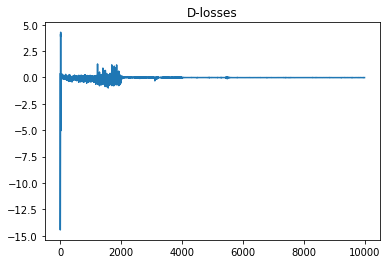

In [ ]:
plt.plot(D_losses)
plt.title('D-losses')
plt.show()

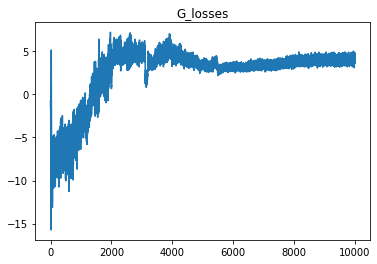

In [ ]:
plt.plot(G_losses)
plt.title('G_losses')
plt.show()

In [ ]:
def test_result(model_para,jump_para,jumptype,generator,show_scatter):
    test_data = real_data(model_para['npaths'],model_para['nsteps'],model_para['ndepths'],
                 model_para['S0'],model_para['mu'],model_para['sigma'],model_para['T'],
                 jump_para=jump_para,jumptype=jumptype)
    delta_t = model_para['T']/float(model_para['nsteps'])
    batch_size = model_para['npaths']
    latent_dim = model_para['ndepths']
    GAN_Monte = np.zeros([batch_size,model_para['nsteps']+1,latent_dim])
    GAN_Monte[:,0,:] = np.log(model_para['S0'])
    dt = torch.torch.tensor(np.ones([batch_size,latent_dim])*delta_t, dtype=torch.float32)
    dt = dt.to(device)

    for i in range(model_para['nsteps']):
        z = np.random.normal(0.0, 1.0,[batch_size,latent_dim])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(device)

        X0 = test_data['MonteGBMX'][:,i,:]
        x0 = torch.tensor(X0,dtype=torch.float32)
        x0 = x0.to(device)
        conditional_fake_latent_samples = torch.cat((z,dt,x0),-1) #x0
        G_z = generator(conditional_fake_latent_samples)
        GAN_Monte[:,i+1,:] = G_z.cpu().detach().numpy()

    # plot when npaths = 10
    # x = np.linspace(0,model_para['T'],model_para['nsteps']+1)
    # for j in range(batch_size):
    #     if show_scatter == True:
    #         for k in range(latent_dim):
    #             plt.scatter(x,np.exp(GAN_Monte[j,:,k]),s=10,c = 'red',alpha = 0.2)
    #     plt.plot(x,test_data['GBMS'][j],label = 'exact')
    #     plt.plot(x,np.exp(np.mean(GAN_Monte[j],1)),label = 'WGAN')
    # plt.legend()
    # plt.show()
    return test_data, GAN_Monte



In [ ]:
step = 500
test_model_para = dict(npaths = 10000,nsteps = step,ndepths = 10,S0 = 100,mu = 0.05,sigma = 0.2,T = step * 0.1)
merton_jump_para = dict(xiP = 1, muJ = -1.0, sigmaJ = 0.2)
test_data,test_GBM_Montepaths = test_result(test_model_para,merton_jump_para,jumpType.mertonJ,generator,show_scatter = False)


Jump intensity:  0.1
jumptype: MertonJ


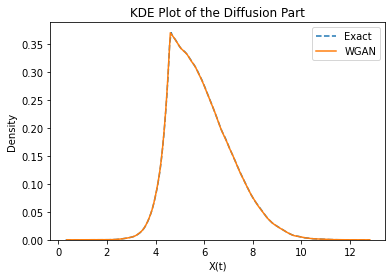

In [ ]:
sns.kdeplot(np.reshape(test_data['MonteGBMX'],-1), linestyle='--',label = 'Exact')
sns.kdeplot(np.reshape(test_GBM_Montepaths,-1), linestyle='-',label = 'WGAN')
plt.xlabel('X(t)')
plt.legend()
plt.title('KDE Plot of the Diffusion Part')
plt.show()

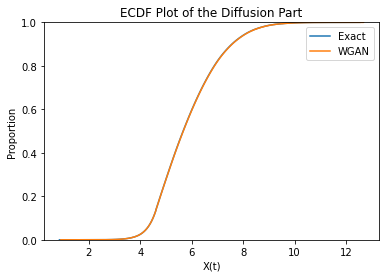

In [ ]:
sns.ecdfplot(np.reshape(test_data['MonteGBMX'],-1), label = 'Exact')
sns.ecdfplot(np.reshape(test_GBM_Montepaths,-1), label = 'WGAN')
plt.xlabel('X(t)')
plt.legend()
plt.title('ECDF Plot of the Diffusion Part')
plt.show()

In [ ]:
Q = np.reshape(test_data['MonteGBMX'],-1)
P = np.reshape(test_GBM_Montepaths,-1)
print('KL:',sum(rel_entr(P, Q)))
print('JS:',distance.jensenshannon(P,Q))
print('W:',wasserstein_distance(P,Q))

KL: 378637.6282765241
JS: 0.007929095768510114
W: 0.006181582164264591


In [ ]:
np.mean(test_GBM_Montepaths,2).shape


(10000, 501)

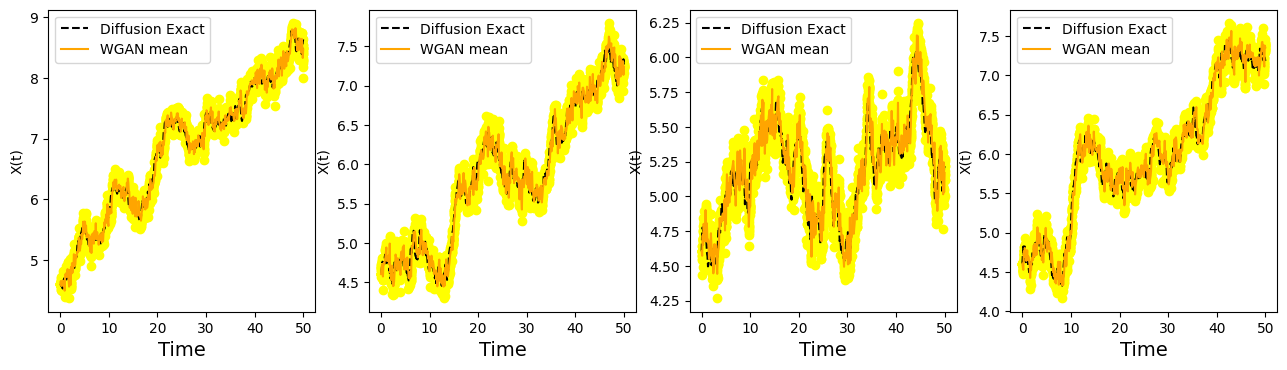

In [ ]:
plt.figure(dpi=100,figsize=(20,4))
x0 = 0
x1 = 501
x = np.linspace(0,50,501)
N = np.random.randint(10000, size = 4)

             

for i in np.arange(1,5):
    plt.subplot(1,5,i)
    plt.plot(x,test_data['GBMX'][N[i-1]][x0:x1],label='Diffusion Exact',linestyle='--',color='black')
    plt.plot(x,np.mean(test_GBM_Montepaths,2)[N[i-1]][x0:x1], label = 'WGAN mean', color = 'orange')
    for k in range(model_para['ndepths']):
        plt.scatter(x,test_GBM_Montepaths[[N[i-1]],x0:x1,k],color = 'yellow')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('X(t)')
    plt.legend(fontsize=10)

plt.savefig('Four exact and GAN generated random paths (GBM).png')

plt.show()
# plt.figure(dpi=100,figsize=(20,4))
# x = np.linspace(x0,x1,x1-x0)
# for i in np.arange(1,5):
#     plt.subplot(1,5,i)
#     plt.plot(x,test_data['JS'][N[i-1]][x0:x1],label='Exact Jump',linestyle='--',color='black')
#     plt.plot(x,jumpS_GAN_paths[N[i-1]][x0:x1],label='WGAN Jump')
    
#     plt.xlabel('$t$',fontsize=14)
#     plt.legend(fontsize=10)

# plt.savefig('Four exact and GAN generated random paths (FixJ).png')
# plt.show()

### **hyper-parameters tuning**

In [ ]:
def training_dataset(model_para,jump_para,jumptype):
    paths =int( model_para['npaths']/5)
    initialS0 = [int(model_para['S0']/100),int(model_para['S0']/10),model_para['S0'],int(model_para['S0']*10),int(model_para['S0']*100)] #
    MonteX = np.zeros([model_para['npaths'],model_para['nsteps']+1,model_para['ndepths']])
    X = np.zeros([model_para['npaths'],model_para['nsteps']+1])
    for l in range(5):
        data = real_data(paths,model_para['nsteps'],model_para['ndepths'],
                    initialS0[l],model_para['mu'],model_para['sigma'],model_para['T'],
                    jump_para=jump_para,jumptype=jumptype)
        MonteX[paths*l: paths*(l+1),:,:] = data['MonteGBMX']
        X[paths*l: paths*(l+1),:] = data['GBMX']
    X = torch.tensor(X,dtype=torch.float32)
    
    MonteX = torch.tensor(MonteX,dtype=torch.float32)       
    data = TensorDataset(MonteX,X) 
    return data

def validation_dataset(model_para,jump_para,jumptype):
    paths =int( model_para['npaths']/5)
    initialS0 = [int(model_para['S0']/100),int(model_para['S0']/10),model_para['S0'],int(model_para['S0']*10),int(model_para['S0']*100)] #
    MonteX = np.zeros([model_para['npaths'],model_para['nsteps']+1,model_para['ndepths']])
    X = np.zeros([model_para['npaths'],model_para['nsteps']+1])
    for l in range(5):
        data = real_data(paths,model_para['nsteps'],model_para['ndepths'],
                    initialS0[l],model_para['mu'],model_para['sigma'],model_para['T'],
                    jump_para=jump_para,jumptype=jumptype)
        MonteX[paths*l: paths*(l+1),:,:] = data['MonteGBMX']
        X[paths*l: paths*(l+1),:] = data['GBMX']
    
    dataset = dict(MonteGBMX = MonteX, GBMX = X)
    return dataset


In [ ]:
# Method 1: fake_samples: E[G_z]
def train_function(critic,generator, training_data,model_para,jump_para, jumptype, batch_size, nepochs, critic_iter,learning_rate,lr_step,lr_gamma,min_lr,gp_lambda):

    optimizer_critic = torch.optim.RMSprop(critic.parameters(), lr=learning_rate)
    optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=learning_rate)
    critic_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_critic, step_size = lr_step, gamma = lr_gamma)
    generator_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size = lr_step, gamma = lr_gamma)

    D_losses = []
    G_losses = []
    Generated_results = []
    # torch.manual_seed(0)
    # np.random.seed(seed=0)
    train_loader = DataLoader(training_data, batch_size, shuffle=True)
    latent_dim = model_para['ndepths']

    for epoch in range(nepochs):
        D_loss_acc = 0
        G_loss_acc = 0

        critic.train()
        generator.train()
        progress_bar = tqdm(train_loader, unit="batch")
       
        for i,[MonteXt,Xt] in enumerate(progress_bar):
    
            Xt = Xt.to(device)  
            MonteXt = MonteXt.to(device)
            
            
            indices = np.random.randint(model_para['nsteps'])

            X0 = np.log(model_para['S0'])
            x0 = torch.torch.tensor(np.ones([Xt.size(0),latent_dim])*X0, dtype=torch.float32) #latent_dim
            x0 = x0.to(device)

            critic_x0 = torch.torch.tensor(np.ones([Xt.size(0),1])*X0, dtype=torch.float32)
            critic_x0 = critic_x0.to(device)

            delta_t = model_para['T']/float(model_para['nsteps'])
            dt = torch.torch.tensor(np.ones([Xt.size(0),latent_dim])*delta_t, dtype=torch.float32)
            dt = dt.to(device)
            
            Monte_X0 = MonteXt[:,indices,:]
            Monte_X0 = Monte_X0.to(device)
            real_Monte_Xt = MonteXt[:,indices+1,:] 
            real_Monte_Xt = real_Monte_Xt.to(device)

            real_Xt = Xt[:,indices+1].view(-1,1)
            real_Xt = real_Xt.to(device)
       

            for p in critic.parameters():
                p.requires_grad = True

            # Training the discriminator
            for iter in range(critic_iter):

                # initialize latent variable z from 1-dim N(0,1)
                z = np.random.normal(0.0, 1.0,[Xt.size(0),latent_dim])
                z = torch.tensor(z,dtype=torch.float32)
                z = z.to(device) 
 
                conditional_real_samples = torch.cat((real_Monte_Xt,dt,Monte_X0),-1) #x0
                conditional_fake_latent_samples = torch.cat((z,dt,Monte_X0),-1) #x0
                
                G_z = generator(conditional_fake_latent_samples)
                mean_fake_samples = torch.mean(G_z,1,True)
                #print(mean_fake_samples.size())

                conditional_fake_samples = torch.cat((G_z,dt,Monte_X0),-1) #x0,

                
                critic.zero_grad()
                
                # Add gradient penalty
                gradient_penalty = calculate_gradient_penalty(critic, Xt.size(0),conditional_real_samples,conditional_fake_samples,gp_lambda) #latent_dim
                gradient_penalty.backward(retain_graph=True)

                loss_D = critic(conditional_fake_samples).mean() - critic(conditional_real_samples).mean() + gradient_penalty
                loss_D.backward(retain_graph=True)
                optimizer_critic.step()

                D_loss_acc += loss_D.item()

            # Training the generator

            z = np.random.normal(0.0, 1.0,[Xt.size(0),latent_dim])
            z = torch.tensor(z,dtype=torch.float32)
            z = z.to(device)

            conditional_fake_latent_samples = torch.cat((z,dt,Monte_X0),-1)
            for p in critic.parameters():
                p.requires_grad = False

            generator.zero_grad()
            G_z = generator(conditional_fake_latent_samples)

            # save the generated result: X(t+1)
            generated_pattern = G_z.cpu().detach().numpy()
            Generated_results.append(generated_pattern)

            mean_fake_samples = torch.mean(G_z,1,True)
            conditional_fake_samples = torch.cat((G_z,dt,Monte_X0),-1) #x0,
            loss_G = - critic(conditional_fake_samples).mean()
            loss_G.backward()
            optimizer_generator.step()
            
            G_loss_acc += loss_G.item()  
                
            progress_bar.set_description(f"Epoch {epoch+1}")
            progress_bar.set_postfix(avg_D_loss=D_loss_acc / (i*critic_iter+1), avg_G_loss=G_loss_acc / (i+1))

            D_losses.append(loss_D.item())
            G_losses.append(loss_G.item()) 
  
        if generator_scheduler.get_last_lr()[0] > min_lr:
            generator_scheduler.step()

        if critic_scheduler.get_last_lr()[0] > min_lr:
            critic_scheduler.step()

    return generator,critic,D_losses, G_losses, Generated_results
    

In [ ]:
def validation_fuction(critic,generator,validation_data,model_para,jump_para, jumptype):
    delta_t = model_para['T']/float(model_para['nsteps'])
    batch_size = model_para['npaths']
    latent_dim = model_para['ndepths']
    GAN_Monte = np.zeros([batch_size,latent_dim])
    #GAN_Monte[:,0,:] = np.log(model_para['S0'])
    dt = torch.torch.tensor(np.ones([batch_size,latent_dim])*delta_t, dtype=torch.float32)
    dt = dt.to(device)

    z = np.random.normal(0.0, 1.0,[batch_size,latent_dim])
    z = torch.tensor(z,dtype=torch.float32)
    z = z.to(device)

    x0 = torch.torch.tensor(np.ones([batch_size,latent_dim])*np.log(model_para['S0']), dtype=torch.float32)
    x0 = x0.to(device)
    conditional_fake_latent_samples = torch.cat((z,dt,x0),-1) #x0
    G_z = generator(conditional_fake_latent_samples)
    GAN_Monte = G_z.cpu().detach().numpy()
    P = np.reshape(GAN_Monte,-1)
    Q = np.reshape(validation_data['MonteGBMX'],-1)
    
    # print('KL:',sum(rel_entr(P, Q)))
    # print('JS:',distance.jensenshannon(P,Q))
    # print('W:',wasserstein_distance(P,Q))
    return wasserstein_distance(P,Q)

Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
Jump intensity:  0.01
jumptype: MertonJ
learning_rate: 0.001  batch_size: 100  lambda: 10  critic_iter: 11 lr_step: 30 lr_gamma: 0.1 min_lr: 1e-07


Epoch 100: 100%|██████████| 100/100 [00:07<00:00, 13.34batch/s, avg_D_loss=-4.56e-5, avg_G_loss=3.41]


learning_rate: 5.438450036622157e-05  batch_size: 251  lambda: 52  critic_iter: 12 lr_step: 35 lr_gamma: 0.1553469031474795 min_lr: 5.585424463038575e-07


Epoch 100: 100%|██████████| 40/40 [00:03<00:00, 10.58batch/s, avg_D_loss=-.00113, avg_G_loss=-1.3]


learning_rate: 0.0003312933829906353  batch_size: 91  lambda: 58  critic_iter: 9 lr_step: 21 lr_gamma: 0.348053907574309 min_lr: 7.686224537553418e-07


Epoch 100: 100%|██████████| 110/110 [00:06<00:00, 15.79batch/s, avg_D_loss=0.000791, avg_G_loss=3.03]


learning_rate: 7.360962168123522e-05  batch_size: 121  lambda: 82  critic_iter: 11 lr_step: 45 lr_gamma: 0.6045088091554432 min_lr: 3.309079726534984e-07


Epoch 100: 100%|██████████| 83/83 [00:06<00:00, 12.94batch/s, avg_D_loss=-.00143, avg_G_loss=1.65]


learning_rate: 2.1985590354012786e-05  batch_size: 172  lambda: 65  critic_iter: 9 lr_step: 26 lr_gamma: 0.24718920104967296 min_lr: 7.729979460279825e-07


Epoch 100: 100%|██████████| 59/59 [00:03<00:00, 15.04batch/s, avg_D_loss=-.0111, avg_G_loss=-.413]


learning_rate: 0.0012128886980973294  batch_size: 36  lambda: 45  critic_iter: 6 lr_step: 23 lr_gamma: 0.17139134916380921 min_lr: 9.798409738698354e-08


Epoch 100: 100%|██████████| 278/278 [00:12<00:00, 22.21batch/s, avg_D_loss=-5.06e-5, avg_G_loss=-.952]


learning_rate: 1.8079213923598458e-05  batch_size: 109  lambda: 96  critic_iter: 11 lr_step: 14 lr_gamma: 0.6981864971388105 min_lr: 3.396211207140313e-07


Epoch 100: 100%|██████████| 92/92 [00:06<00:00, 13.37batch/s, avg_D_loss=-.000344, avg_G_loss=2.06]


learning_rate: 9.393346283726135e-05  batch_size: 165  lambda: 2  critic_iter: 7 lr_step: 30 lr_gamma: 0.6191484912057785 min_lr: 7.806945590885682e-07


Epoch 100: 100%|██████████| 61/61 [00:03<00:00, 18.20batch/s, avg_D_loss=-.000419, avg_G_loss=-.161]


learning_rate: 0.0005556568554766097  batch_size: 82  lambda: 97  critic_iter: 12 lr_step: 38 lr_gamma: 0.8031077194681547 min_lr: 4.492205715593401e-07


Epoch 100: 100%|██████████| 122/122 [00:09<00:00, 12.34batch/s, avg_D_loss=-.147, avg_G_loss=-4.75]


learning_rate: 3.751083283131823e-05  batch_size: 143  lambda: 68  critic_iter: 5 lr_step: 40 lr_gamma: 0.5186642844776078 min_lr: 5.509140015455478e-07


Epoch 100: 100%|██████████| 70/70 [00:02<00:00, 23.41batch/s, avg_D_loss=0.000281, avg_G_loss=2.23]


learning_rate: 0.0016140640314974014  batch_size: 140  lambda: 21  critic_iter: 4 lr_step: 14 lr_gamma: 0.3032255661628902 min_lr: 1.1812207996397271e-07


Epoch 100: 100%|██████████| 72/72 [00:02<00:00, 28.72batch/s, avg_D_loss=0.00096, avg_G_loss=4.13]


learning_rate: 0.0008011683163530925  batch_size: 109  lambda: 100  critic_iter: 4 lr_step: 21 lr_gamma: 0.1511763097175373 min_lr: 7.852347075616262e-07


Epoch 100: 100%|██████████| 92/92 [00:03<00:00, 29.31batch/s, avg_D_loss=0.000276, avg_G_loss=1.93]


learning_rate: 3.771114059226237e-05  batch_size: 63  lambda: 98  critic_iter: 9 lr_step: 10 lr_gamma: 0.42045681535178747 min_lr: 6.680479116196033e-08


Epoch 100: 100%|██████████| 159/159 [00:09<00:00, 15.99batch/s, avg_D_loss=0.00022, avg_G_loss=2.87]


learning_rate: 0.004387106864705555  batch_size: 116  lambda: 80  critic_iter: 8 lr_step: 18 lr_gamma: 0.8125345227307993 min_lr: 2.5281283474467067e-07


Epoch 100: 100%|██████████| 87/87 [00:05<00:00, 17.34batch/s, avg_D_loss=-.141, avg_G_loss=-2.3]


learning_rate: 0.007391116720314618  batch_size: 62  lambda: 63  critic_iter: 10 lr_step: 21 lr_gamma: 0.40650285836648425 min_lr: 1e-06


Epoch 100: 100%|██████████| 162/162 [00:11<00:00, 14.42batch/s, avg_D_loss=0.000623, avg_G_loss=-2.12]


learning_rate: 0.0002971503710628059  batch_size: 106  lambda: 54  critic_iter: 6 lr_step: 11 lr_gamma: 0.2519757733603335 min_lr: 6.483563034121656e-08


Epoch 100: 100%|██████████| 95/95 [00:04<00:00, 20.88batch/s, avg_D_loss=0.000723, avg_G_loss=-.792]


learning_rate: 0.00022580338107368715  batch_size: 140  lambda: 87  critic_iter: 11 lr_step: 22 lr_gamma: 0.3597525687568959 min_lr: 7.640821512398736e-07


Epoch 100: 100%|██████████| 72/72 [00:05<00:00, 13.18batch/s, avg_D_loss=0.000553, avg_G_loss=9.09]


learning_rate: 0.000422522889526062  batch_size: 68  lambda: 12  critic_iter: 9 lr_step: 18 lr_gamma: 0.3749848291733914 min_lr: 7.347923409036753e-07


Epoch 100: 100%|██████████| 148/148 [00:09<00:00, 16.03batch/s, avg_D_loss=-1.21e-5, avg_G_loss=1.59]


learning_rate: 0.00041918909671114694  batch_size: 224  lambda: 69  critic_iter: 8 lr_step: 21 lr_gamma: 0.40515571533189954 min_lr: 7.576630083464696e-07


Epoch 100: 100%|██████████| 45/45 [00:02<00:00, 15.68batch/s, avg_D_loss=5.3e-5, avg_G_loss=0.449]


learning_rate: 3.0141641554788388e-05  batch_size: 76  lambda: 74  critic_iter: 9 lr_step: 23 lr_gamma: 0.4826587644785044 min_lr: 7.699533025117062e-07


Epoch 100: 100%|██████████| 132/132 [00:08<00:00, 16.13batch/s, avg_D_loss=0.000133, avg_G_loss=1.31]


learning_rate: 0.000667520816140913  batch_size: 206  lambda: 40  critic_iter: 9 lr_step: 25 lr_gamma: 0.4892678134990738 min_lr: 7.68293651288839e-07


Epoch 100: 100%|██████████| 49/49 [00:03<00:00, 15.31batch/s, avg_D_loss=-.00884, avg_G_loss=-3.3]


learning_rate: 0.00032470921538554773  batch_size: 16  lambda: 29  critic_iter: 8 lr_step: 40 lr_gamma: 0.3918747432981319 min_lr: 8.871510680883247e-07


Epoch 100: 100%|██████████| 625/625 [00:35<00:00, 17.57batch/s, avg_D_loss=0.000644, avg_G_loss=-8.73]


learning_rate: 0.00031236392744826594  batch_size: 41  lambda: 81  critic_iter: 11 lr_step: 21 lr_gamma: 0.258903414410781 min_lr: 9.118891199294189e-07


Epoch 100: 100%|██████████| 244/244 [00:17<00:00, 13.57batch/s, avg_D_loss=-2.93e-5, avg_G_loss=9.73]


learning_rate: 0.0006081360171401834  batch_size: 110  lambda: 95  critic_iter: 9 lr_step: 21 lr_gamma: 0.6568367752123845 min_lr: 4.80822814631781e-07


Epoch 100: 100%|██████████| 91/91 [00:05<00:00, 15.64batch/s, avg_D_loss=0.00235, avg_G_loss=0.279]


learning_rate: 0.00026149577283978424  batch_size: 26  lambda: 12  critic_iter: 9 lr_step: 40 lr_gamma: 0.1881534564519931 min_lr: 9.098382434924389e-07


Epoch 100: 100%|██████████| 385/385 [00:24<00:00, 16.02batch/s, avg_D_loss=-2.58e-5, avg_G_loss=-9.64]


learning_rate: 0.00029215523935915673  batch_size: 34  lambda: 7  critic_iter: 9 lr_step: 16 lr_gamma: 0.5862663112543108 min_lr: 7.387566516005282e-07


Epoch 100: 100%|██████████| 295/295 [00:18<00:00, 15.69batch/s, avg_D_loss=-9.59e-5, avg_G_loss=4.33]


learning_rate: 0.0002837574630581938  batch_size: 164  lambda: 10  critic_iter: 9 lr_step: 17 lr_gamma: 0.32967789660946917 min_lr: 7.534344756379302e-07


Epoch 100: 100%|██████████| 61/61 [00:04<00:00, 15.09batch/s, avg_D_loss=-.00165, avg_G_loss=-1.81]


learning_rate: 0.0003435582114710517  batch_size: 171  lambda: 99  critic_iter: 9 lr_step: 20 lr_gamma: 0.36404128862624796 min_lr: 7.975133434445831e-07


Epoch 100: 100%|██████████| 59/59 [00:03<00:00, 15.36batch/s, avg_D_loss=0.000937, avg_G_loss=-6.81]


learning_rate: 0.0012193374583399003  batch_size: 17  lambda: 59  critic_iter: 9 lr_step: 15 lr_gamma: 0.299141010480542 min_lr: 3.753041384755703e-08


Epoch 100: 100%|██████████| 589/589 [00:36<00:00, 15.93batch/s, avg_D_loss=8.08e-6, avg_G_loss=-16.6]


learning_rate: 0.00021610870994237917  batch_size: 229  lambda: 54  critic_iter: 9 lr_step: 24 lr_gamma: 0.4381630361622324 min_lr: 7.717331947278371e-08


Epoch 100: 100%|██████████| 44/44 [00:03<00:00, 13.24batch/s, avg_D_loss=9.68e-5, avg_G_loss=10]


learning_rate: 0.0002736591892497243  batch_size: 85  lambda: 55  critic_iter: 9 lr_step: 20 lr_gamma: 0.40354311280666344 min_lr: 4.954035801490498e-07


Epoch 100: 100%|██████████| 118/118 [00:08<00:00, 14.21batch/s, avg_D_loss=7.15e-5, avg_G_loss=5.16]


learning_rate: 0.0002934697565704154  batch_size: 90  lambda: 39  critic_iter: 9 lr_step: 19 lr_gamma: 0.3211205372673642 min_lr: 7.005743282369787e-07


Epoch 100: 100%|██████████| 112/112 [00:07<00:00, 15.10batch/s, avg_D_loss=-.000189, avg_G_loss=-7.06]


learning_rate: 0.00024068831097334841  batch_size: 210  lambda: 59  critic_iter: 9 lr_step: 21 lr_gamma: 0.8767393684043974 min_lr: 4.5949232025225763e-07


Epoch 100: 100%|██████████| 48/48 [00:03<00:00, 14.10batch/s, avg_D_loss=-.0926, avg_G_loss=-1.91]


learning_rate: 0.008844510934584864  batch_size: 63  lambda: 81  critic_iter: 9 lr_step: 14 lr_gamma: 0.12096990777868212 min_lr: 6.885623130420662e-07


Epoch 100: 100%|██████████| 159/159 [00:10<00:00, 15.37batch/s, avg_D_loss=-.000762, avg_G_loss=3.88]


learning_rate: 0.0007965584878959146  batch_size: 62  lambda: 92  critic_iter: 9 lr_step: 23 lr_gamma: 0.3407361288888937 min_lr: 7.542957549392192e-07


Epoch 100: 100%|██████████| 162/162 [00:10<00:00, 15.59batch/s, avg_D_loss=3.57e-5, avg_G_loss=-1.28]


learning_rate: 0.003070407449036062  batch_size: 228  lambda: 59  critic_iter: 9 lr_step: 34 lr_gamma: 0.3541245205081295 min_lr: 6.635895115618311e-07


Epoch 100: 100%|██████████| 44/44 [00:03<00:00, 13.13batch/s, avg_D_loss=-.0675, avg_G_loss=5.34]


learning_rate: 0.000382321879949276  batch_size: 28  lambda: 58  critic_iter: 7 lr_step: 20 lr_gamma: 0.3304816002785397 min_lr: 9.625804598893207e-07


Epoch 100: 100%|██████████| 358/358 [00:18<00:00, 19.19batch/s, avg_D_loss=-6.6e-5, avg_G_loss=-2.31]


learning_rate: 0.00033279201108880543  batch_size: 87  lambda: 55  critic_iter: 10 lr_step: 21 lr_gamma: 0.35997115355961906 min_lr: 8.718268127765056e-07


Epoch 100: 100%|██████████| 115/115 [00:07<00:00, 14.45batch/s, avg_D_loss=8.25e-5, avg_G_loss=2.38]


learning_rate: 0.0003083011126224684  batch_size: 49  lambda: 92  critic_iter: 9 lr_step: 24 lr_gamma: 0.318791265268077 min_lr: 5.395646864098086e-07


Epoch 100: 100%|██████████| 205/205 [00:13<00:00, 15.65batch/s, avg_D_loss=1.53e-6, avg_G_loss=7.85]


learning_rate: 0.0006598998534687082  batch_size: 177  lambda: 59  critic_iter: 9 lr_step: 18 lr_gamma: 0.3148549264072896 min_lr: 8.00427225795018e-07


Epoch 100: 100%|██████████| 57/57 [00:03<00:00, 15.37batch/s, avg_D_loss=6.47e-5, avg_G_loss=5.81]


learning_rate: 0.0003412922336240376  batch_size: 85  lambda: 58  critic_iter: 12 lr_step: 30 lr_gamma: 0.25097713100362484 min_lr: 3.744562771890082e-07


Epoch 100: 100%|██████████| 118/118 [00:09<00:00, 12.04batch/s, avg_D_loss=8.34e-5, avg_G_loss=-.391]


learning_rate: 0.0008862416842419534  batch_size: 51  lambda: 58  critic_iter: 9 lr_step: 35 lr_gamma: 0.12142708348711731 min_lr: 9.229641625467362e-07


Epoch 100: 100%|██████████| 197/197 [00:12<00:00, 15.87batch/s, avg_D_loss=-2.54e-5, avg_G_loss=-2.36]


learning_rate: 1.105699782240496e-05  batch_size: 96  lambda: 3  critic_iter: 10 lr_step: 18 lr_gamma: 0.20988140667169497 min_lr: 1.117401350309041e-07


Epoch 100: 100%|██████████| 105/105 [00:07<00:00, 14.21batch/s, avg_D_loss=-.0497, avg_G_loss=-.955]


learning_rate: 0.00021566273550322065  batch_size: 83  lambda: 59  critic_iter: 9 lr_step: 20 lr_gamma: 0.18058864142045064 min_lr: 7.131348959143609e-07


Epoch 100: 100%|██████████| 121/121 [00:07<00:00, 15.49batch/s, avg_D_loss=3.99e-5, avg_G_loss=-6.76]


learning_rate: 0.00022775625123582985  batch_size: 107  lambda: 7  critic_iter: 9 lr_step: 17 lr_gamma: 0.5485837652575167 min_lr: 4.0225519609974035e-07


Epoch 100: 100%|██████████| 94/94 [00:06<00:00, 15.38batch/s, avg_D_loss=7.96e-5, avg_G_loss=-1.91]


learning_rate: 4.8658573409419434e-05  batch_size: 110  lambda: 1  critic_iter: 9 lr_step: 15 lr_gamma: 0.7235272599950767 min_lr: 9.61104274219662e-07


Epoch 100: 100%|██████████| 91/91 [00:05<00:00, 15.18batch/s, avg_D_loss=-.000273, avg_G_loss=2.77]


learning_rate: 0.00010872784819487633  batch_size: 123  lambda: 1  critic_iter: 13 lr_step: 11 lr_gamma: 0.8485749658886349 min_lr: 2.2494699598636843e-07


Epoch 100: 100%|██████████| 82/82 [00:07<00:00, 11.23batch/s, avg_D_loss=-.00211, avg_G_loss=-2.46]


learning_rate: 0.0011732928948027341  batch_size: 245  lambda: 5  critic_iter: 3 lr_step: 50 lr_gamma: 0.5751280316571804 min_lr: 7.507908693722332e-07


Epoch 100: 100%|██████████| 41/41 [00:01<00:00, 28.75batch/s, avg_D_loss=-.196, avg_G_loss=-1.54]


learning_rate: 1.0518260818677679e-05  batch_size: 245  lambda: 2  critic_iter: 3 lr_step: 47 lr_gamma: 0.6566351368346457 min_lr: 2.1012429676374684e-07


Epoch 100: 100%|██████████| 41/41 [00:01<00:00, 28.60batch/s, avg_D_loss=-.0386, avg_G_loss=-6.56]


learning_rate: 1.151706275937194e-05  batch_size: 211  lambda: 9  critic_iter: 10 lr_step: 10 lr_gamma: 0.8337183709911801 min_lr: 3.659036066124466e-07


Epoch 100: 100%|██████████| 48/48 [00:03<00:00, 12.90batch/s, avg_D_loss=-.0412, avg_G_loss=-4.2]


---------------------------RESULTS--------------------------
[0.0003312933829906353, 91, 58, 9, 21, 0.348053907574309, 7.686224537553418e-07]


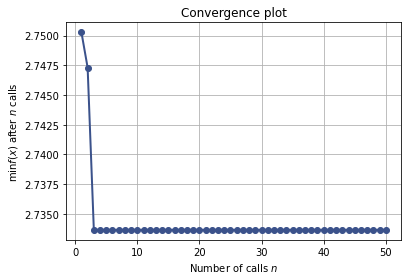

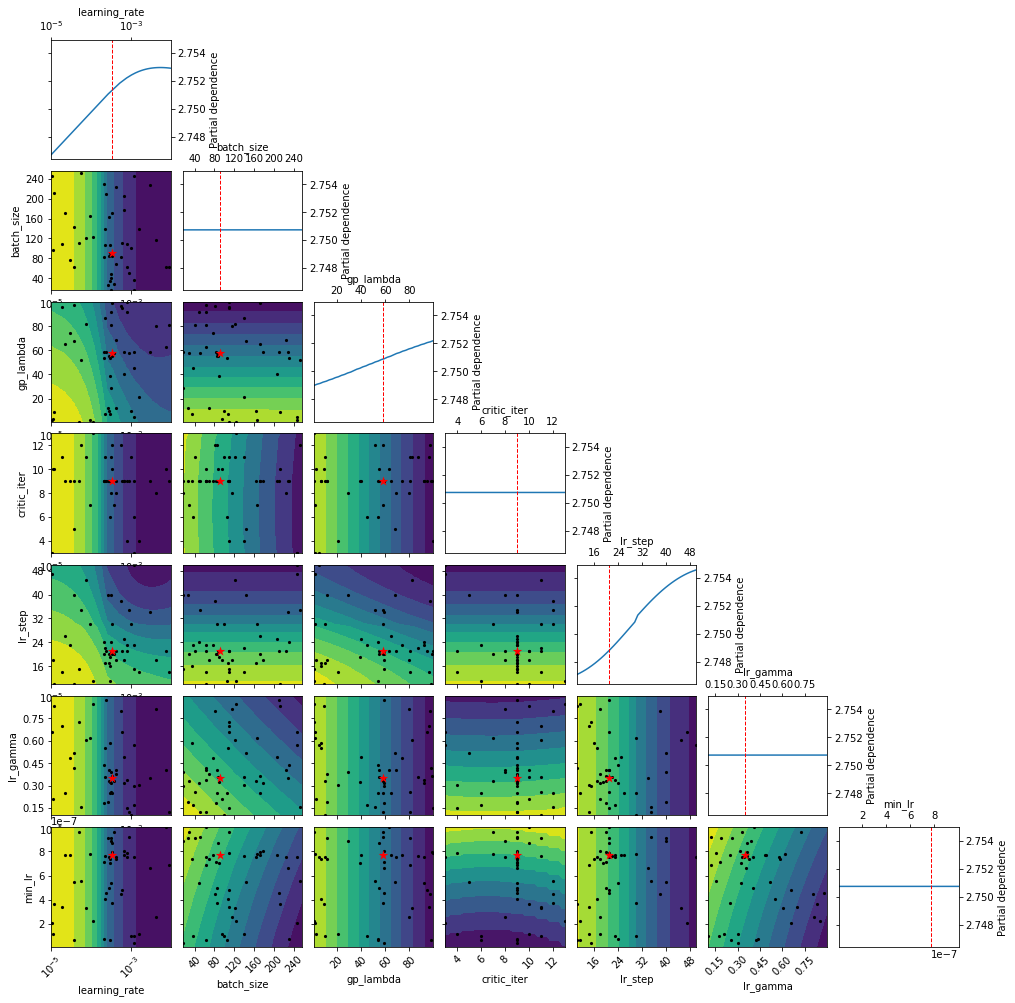

In [ ]:
nepochs = 100
batch_size = 10

# Define the search space
dim_learning_rate = Real(low=1e-5, high=1e-2, prior='log-uniform', name='learning_rate')
#dim_activation = Categorical(categories=[nn.ReLU(), nn.LeakyReLU(0.1)], name='activation')
dim_batch_size = Integer(low=16, high=256, name='batch_size')
dim_lambda = Integer(low=1, high=100, name="gp_lambda") #try Integer
dim_critic_iter = Integer(low=3, high=13, name='critic_iter')
dim_lr_step = Integer(low=10, high=50, name='lr_step')
dim_lr_gamma = Real(low=0.1, high=0.9, name='lr_gamma')
dim_min_lr = Real(low=1e-8, high=1e-6, name='min_lr')

dimensions = [dim_learning_rate,
              #dim_activation,
              dim_batch_size,
              dim_lambda,
              dim_critic_iter,
              dim_lr_step,
              dim_lr_gamma,
              dim_min_lr
             ]
#default_parameters = [1e-3, 'relu', 256, 10, 11,30,0.1,1e-7]
default_parameters = [1e-3,  100, 10, 11,30,0.1,1e-7]
#default_parameters = [1e-3, 10, 11,30,0.1,1e-7]
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, batch_size, gp_lambda,critic_iter,lr_step,lr_gamma,min_lr): #activation, batch_size

    # Set up GAN based on hyperparameters
    # C_hyper['activation'] = activation
    # G_hyper['activation'] = activation
    critic = Critic(**C_hyper).to(device)
    generator = Generator(**G_hyper).to(device)
    print('learning_rate:', learning_rate, ' batch_size:',batch_size,' lambda:',gp_lambda,' critic_iter:',critic_iter,
          'lr_step:',lr_step,'lr_gamma:',lr_gamma,'min_lr:',min_lr)
    # Train GAN
    trained_generator,trained_critic,D_losses, G_losses, Generated_results = train_function(critic, generator, training_data,model_para,merton_jump_para, jumpType.mertonJ, 
                int(batch_size), nepochs, critic_iter,learning_rate,lr_step,lr_gamma,min_lr,gp_lambda)
    
    
    #train_loss = training(train_data, generator, critic)

    # Compute validation loss
    val_loss = validation_fuction(trained_critic,trained_generator,validation_data,validation_model_para,merton_jump_para, jumpType.mertonJ)

    return val_loss

fix_jump_para = dict(xiP = 1, J = 1,p = 0.5)

merton_jump_para = dict(xiP = 1, muJ = -0.05, sigmaJ = 0.2)

model_para = dict(npaths =10000,nsteps = 500,ndepths = 10,S0 = 100,mu = 0.05,sigma = 0.2,T = 500*0.01) # npaths should be divided by 5

validation_model_para = dict(npaths =1000,nsteps = 1,ndepths = 10,S0 = 100,mu = 0.05,sigma = 0.2,T = 0.01) # npaths should be divided by 5

C_hyper = {
        "c_dim": 2 * model_para['ndepths'], 
        "input_dim": model_para['ndepths'],
        "output_dim": 1,
        "hidden_neurons":  [100,100,100,100],
        "activation":nn.LeakyReLU(0.1)
}

G_hyper = {
        "c_dim": 2 * model_para['ndepths'], # Jorino's: 1 
        "input_dim": model_para['ndepths'],
        "output_dim": model_para['ndepths'], #1
        "hidden_neurons": [100,100,100,100],
        "activation":nn.LeakyReLU(0.1)
}
critic = Critic(**C_hyper).to(device)
generator = Generator(**G_hyper).to(device)
training_data = training_dataset(model_para,merton_jump_para,jumpType.mertonJ)
validation_data = validation_dataset(validation_model_para,merton_jump_para,jumpType.mertonJ)

# Run the hyperparameter optimization
gp_result = gp_minimize(
    func=fitness,
    x0=default_parameters,             
    dimensions=dimensions,
    n_calls=50
    )

# Plot convergence of fitness
plot_convergence(gp_result)

# Plot the objective function
plot_objective(gp_result)

# Print best hyperparameters
print('---------------------------RESULTS--------------------------')
print(gp_result.x)

In [ ]:
dimensions

[Real(low=1e-05, high=0.01, prior='log-uniform', transform='normalize'),
 Categorical(categories=('relu', 'elu', 'softplus', 'selu'), prior=None),
 Integer(low=128, high=512, prior='uniform', transform='normalize'),
 Real(low=1, high=100, prior='uniform', transform='normalize')]

In [ ]:
Q.shape

(5010000,)

### **Anomaly detection**

In [ ]:
def testanomalyScore(test_data, paths_para, generator, critic): 
    
    S0 = paths_para['S0']
    
    npaths = paths_para['npaths'] # npaths = 1
    nsteps = paths_para['nsteps']
    ndepths = paths_para['ndepths']
    ExactJX = test_data['jumpX']

    delta_t = paths_para['T']/paths_para['nsteps']

    score = np.zeros([npaths,nsteps+1])
    R_loss = np.zeros([npaths,nsteps])
    D_loss = np.zeros([npaths,nsteps])
    patterns = np.zeros([npaths,nsteps+1,ndepths])
    patterns[:,0,:] = S0
    score[:,0] = 0
    for l in range(npaths):
      for i in range(nsteps):
          z = np.random.normal(0.0, 1.0,[1,ndepths])
          z = torch.tensor(z,dtype=torch.float32)
          z = z.to(device)
          
          dt = torch.tensor(np.ones([1,ndepths])*delta_t, dtype=torch.float32)
          dt = dt.to(device)
          
          x0 = torch.tensor(np.ones([1,ndepths])*ExactJX[l,i], dtype=torch.float32)
          x0 = x0.to(device)
          realX = torch.tensor(np.ones([1,ndepths])*ExactJX[l,i+1], dtype=torch.float32)
          realX = realX.to(device)
          conditional_real_samples = torch.cat((realX,dt,x0),-1)

    
          z_hat = Variable(z, requires_grad=True).to(device)
          opt = torch.optim.Adam([z_hat], lr=0.0001, betas=(0.5, 0.999))
      
          for j in range(50):
              opt.zero_grad()
              #print(z_hat.size())
              conditional_fake_latent_samples = torch.cat((z_hat,dt,x0),-1)
              G_z= generator(conditional_fake_latent_samples) #
              # print(G_z.shape)
              # print(realX.size())
              L_R = torch.linalg.norm(torch.mean(G_z,1)-realX,ord=1)
              #L_R = torch.linalg.norm(G_z-realX,ord=2)

              conditional_fake_samples = torch.cat((G_z,dt,x0),-1) 
        
              L_D = torch.linalg.norm(critic(conditional_fake_samples).view(-1) - critic(conditional_real_samples).view(-1), ord = 1)
              eta = 0.5
              loss = (1-eta) * L_R + eta * L_D
              
              #print(loss.item())
              loss.backward()
              opt.step()
        
          patterns[l,i+1] = np.exp(G_z.cpu().detach().numpy()) #np.exp(G_z.cpu().detach().numpy())
          score[l,i+1] = loss.item()
          
          R_loss[l,i] = L_R.item()
          D_loss[l,i] = L_D.item()
        
        
    return score, R_loss, D_loss, patterns



Jump intensity:  0.05
jumptype: MertonJ


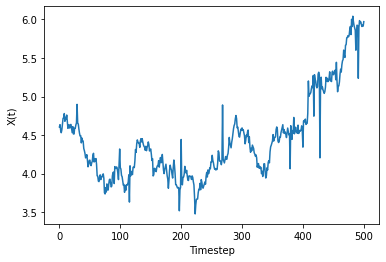

In [ ]:
fix_jump_para = dict(xiP = 1, J = 0.8, p = 0.5)

merton_jump_para = dict(xiP = 0.5, muJ = -0.2, sigmaJ = 0.5)

anomaly_paths_para = dict(npaths = 1,nsteps = 500,ndepths = 10,S0 = 100,mu = 0.05,sigma = 0.2,T = 500 * 0.1)

test_data = real_data(anomaly_paths_para['npaths'],anomaly_paths_para['nsteps'],anomaly_paths_para['ndepths'],
                 anomaly_paths_para['S0'],anomaly_paths_para['mu'],anomaly_paths_para['sigma'],anomaly_paths_para['T'],
                 jump_para=merton_jump_para,jumptype=jumpType.mertonJ)

plt.plot(np.transpose(test_data['jumpX']))
plt.xlabel('Timestep')
plt.ylabel('X(t)')
plt.show()

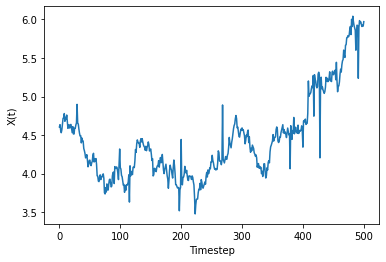

In [ ]:
plt.plot(np.transpose(test_data['jumpX']))
plt.xlabel('Timestep')
plt.ylabel('X(t)')
plt.show()

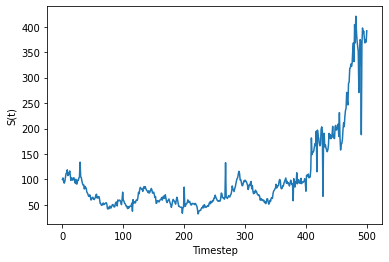

In [ ]:
plt.plot(np.transpose(test_data['jumpS'][0]))
plt.xlabel('Timestep')
plt.ylabel('S(t)')
plt.show()

In [ ]:
score, R_loss, D_loss, reconstruction_pattern = testanomalyScore(test_data, anomaly_paths_para, generator, critic)

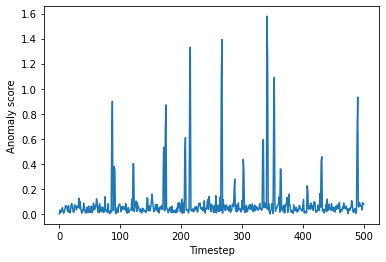

In [ ]:

plt.plot(np.transpose(score))
plt.xlabel('Timestep')
plt.ylabel('Anomaly score')
plt.show()

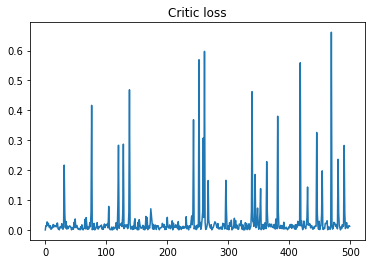

In [ ]:
plt.plot(np.transpose(D_loss))
plt.title('Critic loss')
plt.show()

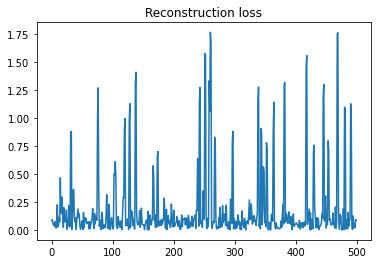

In [ ]:
plt.plot(np.transpose(R_loss))
plt.title('Reconstruction loss')
plt.show()

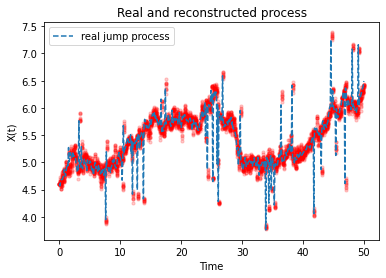

In [ ]:
x = np.linspace(0,anomaly_paths_para['T'],anomaly_paths_para['nsteps']+1)
for k in range(anomaly_paths_para['ndepths']):
    plt.scatter(x,np.log(reconstruction_pattern[0,:,k]),s = 10,c='red',alpha = 0.2)
plt.plot(x,np.transpose(test_data['jumpX']), label = 'real jump process',linestyle = '--')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.legend()
plt.title('Real and reconstructed process')
plt.show()

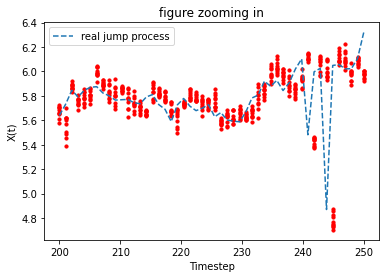

In [ ]:
x0 = 200
x1 = 250

x = np.linspace(x0,x1,x1-x0)
for k in range(anomaly_paths_para['ndepths']):
    plt.scatter(x,np.log(reconstruction_pattern[0,x0:x1,k]),s = 10,c = 'red')
plt.plot(x,np.transpose(np.abs(test_data['jumpX']))[x0:x1], label = 'real jump process',linestyle = '--')

plt.legend()
plt.title('figure zooming in')
plt.xlabel('Timestep')
plt.ylabel('X(t)')
plt.show()

In [ ]:
real_jump = np.nonzero(np.reshape(test_data['Bernoulli'],-1))[0] # position start at t0
print(real_jump)

[ 30  31  85  89 120 143 170 173 205 213 229 242 265 267 286 301 333 340
 351 362 406 429 465 488 491]


In [ ]:
detected_jump = np.nonzero(np.reshape(score[:,1:],-1)-0.2>0)[0]
print(detected_jump)

[ 85  86  89  90 120 121 170 171 173 174 205 206 213 214 265 266 287 301
 302 333 334 340 341 351 352 362 363 406 429 430 488 489]


In [ ]:
position = np.intersect1d(detected_jump,real_jump)
print('Detected jump place:', position)

Detected jump place: [ 85  89 120 170 173 205 213 265 301 333 340 351 362 406 429 488]


In [ ]:
detect_result = np.in1d(detected_jump,real_jump)

true_number = np.count_nonzero(detect_result)
true_percentage = true_number /len(real_jump) * 100
false_percentage = (len(detected_jump)-true_number)/len(real_jump) * 100

print('Accuracy: %.2f'% true_percentage,'%')

print('False detected: %.2f'% false_percentage,'%')

Accuracy: 64.00 %
False detected: 64.00 %


In [ ]:
real_label = np.zeros(len(np.reshape(score[:,1:],-1)))
pred_label = np.zeros(len(np.reshape(score[:,1:],-1)))
pred_label[detected_jump-1] = 1
real_label[real_jump-1] = 1

matrix = confusion_matrix(real_label,pred_label)
precision = matrix[0][0]/(matrix[0][0]+matrix[1][0]) * 100
recall = matrix[0][0]/(matrix[0][0]+matrix[0][1]) * 100
F1 = 2 * precision * recall / (precision + recall)
print('confusion matrix:\n', matrix)

print('Precision: %.2f'% precision,'%')
print('Recall: %.2f'% recall,'%')
print('F1 score: %.2f'% F1)

confusion matrix:
 [[459  16]
 [  9  16]]
Precision: 98.08 %
Recall: 96.63 %
F1 score: 97.35


In [ ]:

generated_pattern = np.log(np.reshape(reconstruction_pattern[:,1:,:], 
                                      (anomaly_paths_para['npaths']*(anomaly_paths_para['nsteps']),
                                       anomaly_paths_para['ndepths']))) #size: [npaths * nsteps,ndepths]
generated_jump_place = generated_pattern[detected_jump] #size: [num(jump),ndepths]
real_jump_place = np.reshape(test_data['jumpX'][:,1:],-1)[detected_jump] # size: num(jump)
previous_state = np.reshape(test_data['jumpX'][:,1:],-1)[detected_jump-1]
detected_jump_size = real_jump_place - np.mean(generated_jump_place,1)

In [ ]:
# generated_pattern = np.log(np.squeeze(reconstruction_pattern, axis=0)) #size: [nsteps+1,ndepths]
# generated_jump_place = generated_pattern[detected_jump] #size: [47,10]
# real_jump_place = np.transpose(test_data['jumpX'][:,detected_jump]) # size: [47,1]
# previous_state = np.transpose(test_data['jumpX'][:,detected_jump-1])
# detected_jump_size = np.mean(real_jump_place - generated_jump_place,1)


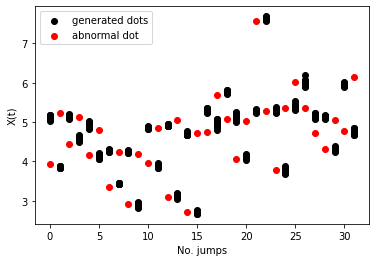

In [ ]:
# plot results
fig,ax = plt.subplots()

x = range(len(detected_jump))

for k in range(anomaly_paths_para['ndepths']):
    ax.scatter(x,generated_jump_place[:,k],c = 'black',label = 'generated dots')
ax.scatter(x,real_jump_place,c='red',label = 'abnormal dot')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[-1]], [labels[0],labels[-1]], loc='best')
plt.xlabel('No. jumps')
plt.ylabel('X(t)')
plt.show()

In [ ]:
xidt = anomaly_paths_para['nsteps']/detected_jump[-1]
print()
xidt

0.982

In [ ]:
# fixed J paras
J_hat = np.abs(detected_jump_size).mean()
print('J: %.6f' % J_hat )

positive_jump = (detected_jump_size > 0).astype(int) # 0-1 array
negative_jump = (detected_jump_size < 0).astype(int)

p_hat = negative_jump.sum()/len(negative_jump)
print('p: %.6f'%p_hat)

xidt = len(detected_jump)/(len(generated_pattern)-1)
print('xi * dt: %.6f'% xidt)

J: 0.929413
p: 0.562500
xi * dt: 0.096192


In [ ]:
#MertonJ paras
muJ_hat, sigmaJ_hat = norm.fit(detected_jump_size,method="MLE")
print('muJ: % .6f' % muJ_hat)
print('sigmaJ: %.6f'% sigmaJ_hat)
xidt = len(detected_jump)/detected_jump[-1]
print('xi * dt: %.6f'% xidt)

muJ: -0.033064
sigmaJ: 1.262827
xi * dt: 0.065440


**Estimated distribution**

In [ ]:
est_merton_para = dict(xiP = 1, muJ = muJ_hat, sigmaJ = sigmaJ_hat)
est_fix_para = dict(xiP = 1,J = J_hat, p = p_hat)
merton_jump_para = dict(xiP = 1, muJ = -0.2, sigmaJ = 1.0)
fix_jump_para = dict(xiP = 1, J = 0.8, p = 0.5)
est_model_para = dict(npaths = 10000,nsteps = 1,ndepths = 1,S0 = 100,mu = 0.05,sigma = 0.2,T = 0.1)
est_jump_data = real_data(est_model_para['npaths'],est_model_para['nsteps'],est_model_para['ndepths'],
                 est_model_para['S0'],est_model_para['mu'],est_model_para['sigma'],xidt,
                 jump_para=est_merton_para,jumptype=jumpType.mertonJ)
real_jump_data = real_data(est_model_para['npaths'],est_model_para['nsteps'],est_model_para['ndepths'],
                 est_model_para['S0'],est_model_para['mu'],est_model_para['sigma'],est_model_para['T'],
                 jump_para=merton_jump_para,jumptype=jumpType.mertonJ)

Jump intensity:  0.09619238476953908
jumptype: MertonJ
Jump intensity:  0.1
jumptype: MertonJ


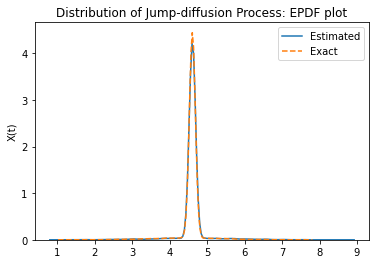

In [ ]:
# sns.kdeplot(np.reshape(real_jump_data['MonteGBMX'][:,1],-1), linestyle='--',label = 'Exact GBM')
sns.kdeplot(np.reshape(est_jump_data['jumpX'][:,1],-1), linestyle='-',label = 'Estimated')
sns.kdeplot(np.reshape(real_jump_data['jumpX'][:,1],-1), linestyle='--',label = 'Exact')

plt.title('Distribution of Jump-diffusion Process: EPDF plot')
plt.xlabel('X(t)')
plt.legend()
plt.show()

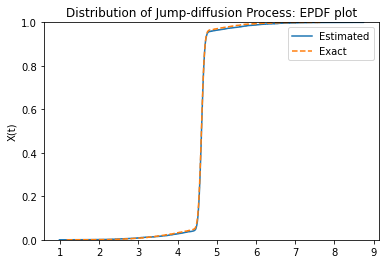

In [ ]:
sns.ecdfplot(np.reshape(est_jump_data['jumpX'][:,1],-1), linestyle='-',label = 'Estimated')
sns.ecdfplot(np.reshape(real_jump_data['jumpX'][:,1],-1), linestyle='--',label = 'Exact')
# sns.ecdfplot(np.reshape(real_jump_data['MonteGBMX'][:,1],-1), linestyle='--',label = 'Exact GBM')
plt.title('Distribution of Jump-diffusion Process: EPDF plot')
plt.xlabel('X(t)')
plt.legend()
plt.show()

In [ ]:
Q = np.reshape(real_jump_data['jumpX'][:,1],-1)
P = np.reshape(est_jump_data['jumpX'][:,1],-1)
print('KL:',sum(rel_entr(P, Q)))
print('JS:',distance.jensenshannon(P,Q))
print('W:',wasserstein_distance(P,Q))

KL: 487.8698780927686
JS: 0.03940355020329316
W: 0.022669529601111016


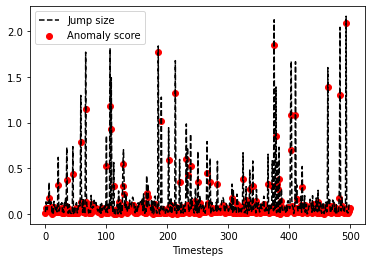

In [ ]:
x = range(anomaly_paths_para['nsteps']*anomaly_paths_para['npaths'])
abs_diff_paths = np.abs((np.mean(generated_pattern,1)-np.reshape(test_data['jumpX'][:,1:],-1)))
plt.plot(x,abs_diff_paths,'--k',label = 'Jump size')
plt.scatter(x,score[:,1:],color = 'red',label = 'Anomaly score')
plt.xlabel('Timesteps')
plt.legend(loc = 'upper left')
plt.show()

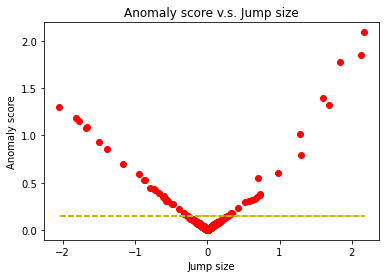

In [ ]:
diff_paths = -(np.mean(generated_pattern,1)-np.reshape(test_data['jumpX'][:,1:],-1))
positive_loc = np.where(diff_paths>0)
negative_loc = np.where(diff_paths<0)
coef_posi = np.polyfit(diff_paths[positive_loc],np.reshape(score[:,1:],-1)[positive_loc],1)
coef_neg = np.polyfit(diff_paths[negative_loc],np.reshape(score[:,1:],-1)[negative_loc],1)
poly1d_fn_posi = np.poly1d(coef_posi) 
poly1d_fn_neg = np.poly1d(coef_neg) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(diff_paths,np.reshape(score[:,1:],-1), 'ro')
# plt.plot(diff_paths[positive_loc], poly1d_fn_posi(diff_paths[positive_loc]), '--k') 
# plt.plot(diff_paths[negative_loc], poly1d_fn_neg(diff_paths[negative_loc]), '--k') 
plt.plot(diff_paths,np.ones(len(diff_paths))*0.15,'--y')
plt.xlabel('Jump size')
plt.ylabel('Anomaly score')
plt.title('Anomaly score v.s. Jump size')
plt.show()

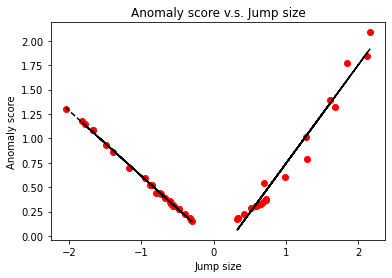

In [ ]:
diff_jump_paths = -(np.mean(generated_pattern,1)-np.reshape(test_data['jumpX'][:,1:],-1))[detected_jump] 
jump_score = np.reshape(score[:,1:],-1)[detected_jump]
positive_loc = np.where(diff_jump_paths>0)
negative_loc = np.where(diff_jump_paths<0)
if len(positive_loc[0])>0:
    coef_posi = np.polyfit(diff_jump_paths[positive_loc],jump_score[positive_loc],1)
if len(negative_loc[0])>0:
    coef_neg = np.polyfit(diff_jump_paths[negative_loc],jump_score[negative_loc],1)
poly1d_fn_posi = np.poly1d(coef_posi) 
poly1d_fn_neg = np.poly1d(coef_neg) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(diff_jump_paths,jump_score,'ro')
plt.plot(diff_jump_paths[positive_loc], poly1d_fn_posi(diff_jump_paths[positive_loc]), '--k') 
plt.plot(diff_jump_paths[negative_loc], poly1d_fn_neg(diff_jump_paths[negative_loc]), '--k') 

plt.xlabel('Jump size')
plt.ylabel('Anomaly score')
plt.title('Anomaly score v.s. Jump size')
plt.show()



In [ ]:
copy = 1000
threshold = 0.15
y_posi = np.random.uniform(0.2,1.0,copy * len(positive_loc[0]))
y_neg = np.random.uniform(0.2,1.0,copy * len(negative_loc[0]))
x_neg = (y_neg-coef_neg[1])/coef_neg[0]
x_posi = (y_posi-coef_posi[1])/coef_posi[0]

new_jump_size = np.concatenate((x_neg,x_posi))

In [ ]:
J_hat = np.abs(new_jump_size).mean()
print('J: %.6f' % J_hat )

J: 1.140314


In [ ]:
muJ_hat, sigmaJ_hat = norm.fit(new_jump_size,method="MLE")
print('muJ: % .6f' % muJ_hat)
print('sigmaJ: %.6f'% sigmaJ_hat)

muJ: -0.173351
sigmaJ: 0.957934


In [ ]:
est_merton_para = dict(xiP = 1, muJ = muJ_hat, sigmaJ = sigmaJ_hat)
est_fix_para = dict(xiP = 1,J = J_hat, p = p_hat)
merton_jump_para = dict(xiP = 1, muJ = -0.2, sigmaJ = 1.0)
fix_jump_para = dict(xiP = 1, J = 0.8, p = 0.5)
est_model_para = dict(npaths = 10000,nsteps = 1,ndepths = 1,S0 = 100,mu = 0.05,sigma = 0.2,T = 0.1)
est_jump_data = real_data(est_model_para['npaths'],est_model_para['nsteps'],est_model_para['ndepths'],
                 est_model_para['S0'],est_model_para['mu'],est_model_para['sigma'],xidt,
                 jump_para=est_merton_para,jumptype=jumpType.mertonJ)
real_jump_data = real_data(est_model_para['npaths'],est_model_para['nsteps'],est_model_para['ndepths'],
                 est_model_para['S0'],est_model_para['mu'],est_model_para['sigma'],est_model_para['T'],
                 jump_para=merton_jump_para,jumptype=jumpType.mertonJ)

Jump intensity:  0.09619238476953908
jumptype: MertonJ
Jump intensity:  0.1
jumptype: MertonJ


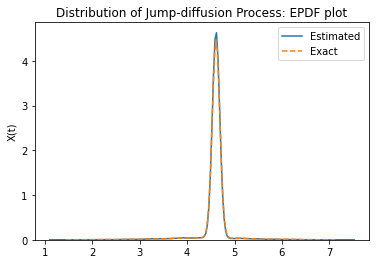

In [ ]:
sns.kdeplot(np.reshape(est_jump_data['jumpX'][:,1],-1), linestyle='-',label = 'Estimated')
sns.kdeplot(np.reshape(real_jump_data['jumpX'][:,1],-1), linestyle='--',label = 'Exact')

plt.title('Distribution of Jump-diffusion Process: EPDF plot')
plt.xlabel('X(t)')
plt.legend()
plt.show()

In [ ]:
Q = np.reshape(real_jump_data['jumpX'][:,1],-1)
P = np.reshape(est_jump_data['jumpX'][:,1],-1)
print('KL:',sum(rel_entr(P, Q)))
print('JS:',distance.jensenshannon(P,Q))
print('W:',wasserstein_distance(P,Q))

KL: 205.9701432818583
JS: 0.03543594949947093
W: 0.010959323955906323


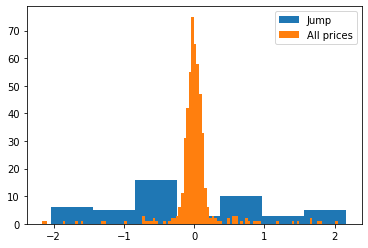

In [ ]:
diff_paths = (np.mean(generated_pattern,1)-np.reshape(test_data['jumpX'][:,1:],-1))
pos,val = np.histogram(detected_jump_size,bins = 100)
_ = plt.hist(detected_jump_size, bins='auto',label = 'Jump')
_ = plt.hist(diff_paths,bins='auto',label = 'All prices')
plt.legend()
plt.show()

In [ ]:
def generate_samples(previous_state, paths_para, generator,iteration): 
    

    npaths = real_jump_place.shape[0]
    nsteps = iteration
    ndepths = paths_para['ndepths']

    delta_t = paths_para['T']/paths_para['nsteps']

    patterns = np.zeros([npaths,nsteps,ndepths])

    for i in range(nsteps):
        z = np.random.normal(0.0, 1.0,[npaths,ndepths])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(device)
        
        dt = torch.tensor(np.ones([npaths,ndepths])*delta_t, dtype=torch.float32)
        dt = dt.to(device)
        
        x0 = torch.tensor(np.ones([npaths,ndepths])*previous_state, dtype=torch.float32)
        x0 = x0.to(device)

        conditional_fake_latent_samples = torch.cat((z,dt,x0),-1)
        G_z= generator(conditional_fake_latent_samples) #
          
        
        patterns[:,i,:] = G_z.cpu().detach().numpy() #np.exp(G_z.cpu().detach().numpy())
     
    return  patterns



**Importance Sampling**

In [ ]:
diff_paths = (np.mean(generated_pattern,1)-np.reshape(test_data['jumpX'][:,1:],-1)) #[timestpes,ndepts]
I_jump = np.zeros(anomaly_paths_para['nsteps']*anomaly_paths_para['npaths'])
I_jump[detected_jump-1] = 1

theta = 100

copy_num = 1000

copy_jump = np.zeros(copy_num * len(I_jump))
for i in range(0,len(copy_jump),len(I_jump)):
    copy_jump[i:i+len(I_jump)] = I_jump

R = len(copy_jump)
p_hat = copy_jump.sum()/(len(copy_jump)) #(I_jump.sum())/len(I_jump)
p_tilde = p_hat * np.exp(theta)/(1-p_hat + p_hat * np.exp(theta) )
f_x = np.random.binomial(1, p_hat,R )
g_x = np.random.binomial(1, p_tilde,R )

numer = sts.beta(f_x.sum()+1,len(f_x)+1-f_x.sum())
denom = sts.beta(g_x.sum()+1,len(g_x)+1-g_x.sum())
# lrNumer = copy_jump#I_jump#f_x
# lrDenom = 
# xx = np.random.beta(g_x.sum()+1,len(g_x)+1-g_x.sum(),R)
# lrNumer = sts.beta.pdf(xx,f_x.sum()+1,len(f_x)+1-f_x.sum())
# lrDenom = sts.beta.pdf(xx,g_x.sum()+1,len(g_x)+1-g_x.sum())
lrNumer = copy_jump
lrDenom = np.random.beta(g_x.sum()+1,len(g_x)+1-g_x.sum(),R)
lrs = lrNumer / lrDenom

# Construct estimate and CI's
ests = lrs * copy_jump #I_jump
ellHat = ests.mean()
sigmaHat = ests.std()
print(ellHat)
print(sigmaHat)
widthCI = 1.96 * sigmaHat / np.sqrt(R)
print(f"IS estimate:\t {ellHat} (+/- {widthCI})")
print(f"IS low bound:\t {ellHat-widthCI}")
print(f"IS upp bound:\t {ellHat+widthCI}")

0.08000080346570769
0.2712959240254567
IS estimate:	 0.08000080346570769 (+/- 0.0016815095580872614)
IS low bound:	 0.07831929390762044
IS upp bound:	 0.08168231302379494


In [ ]:
f_x.sum()/len(f_x)

0.08075

In [ ]:
lrDenom

array([0.99999841, 0.99995145, 0.99998968, ..., 0.99999237, 0.99999498,
       0.9999973 ])

### **Tests**

In [ ]:
def generate_patterns_from_S0(generator,paths_para):
    npaths = real_jump_place.shape[0]
    nsteps = paths_para['nsteps']
    ndepths = paths_para['ndepths']

    delta_t = paths_para['T']/paths_para['nsteps']

    patterns = np.zeros([npaths,nsteps+1,ndepths])
    patterns[:,0,:] = np.log(paths_para['S0'])
    for i in range(nsteps):
        z = np.random.normal(0.0, 1.0,[npaths,ndepths])
        z = torch.tensor(z,dtype=torch.float32)
        z = z.to(device)
        
        dt = torch.tensor(np.ones([npaths,ndepths])*delta_t, dtype=torch.float32)
        dt = dt.to(device)
        
        x0 = torch.tensor(np.ones([npaths,ndepths])*patterns[:,i,:], dtype=torch.float32)
        x0 = x0.to(device)

        conditional_fake_latent_samples = torch.cat((z,dt,x0),-1)
        G_z= generator(conditional_fake_latent_samples) #
          
        
        patterns[:,i+1,:] = G_z.cpu().detach().numpy() #np.exp(G_z.cpu().detach().numpy())
     
    return  patterns


In [ ]:
patterns = generate_patterns_from_S0(generator,anomaly_paths_para)

In [ ]:
patterns.shape

(5, 51, 10)

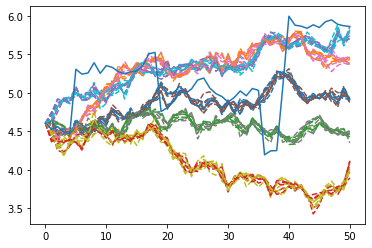

In [ ]:
for i in range(10):
    plt.plot(np.transpose(patterns[:,:,i]),linestyle = '--')
plt.plot(np.transpose(test_data['jumpX']))
plt.show()